In [ ]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
import numpy as np
import scipy.optimize
from scipy.optimize import minimize
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import random
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
import copy
import networkx as nx
from datetime import datetime
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import ast
import re
from networkx.linalg.spectrum import laplacian_spectrum
from itertools import product

import nlopt

from qtensor import parameter_optimization as popt
import torch

### Manually define subgraphs

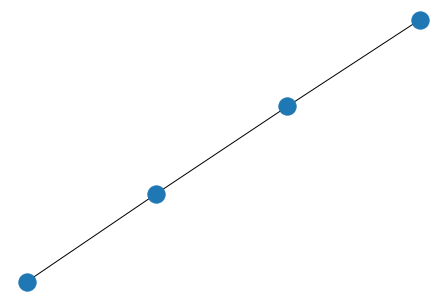

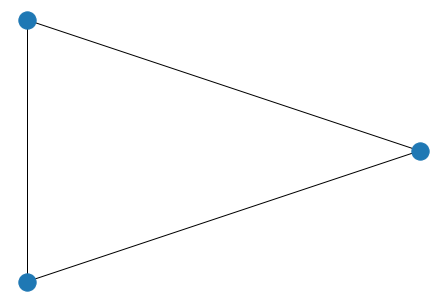

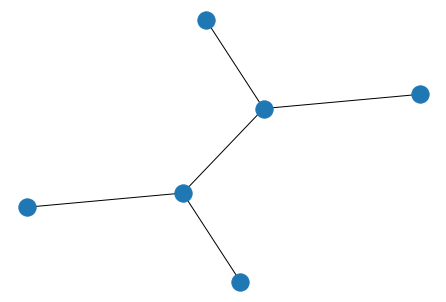

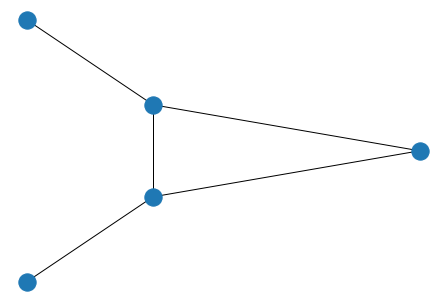

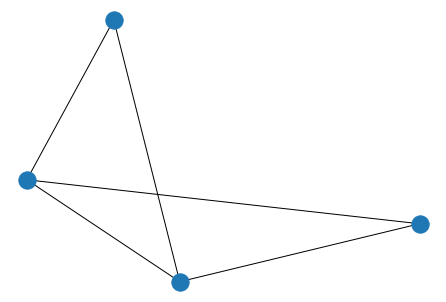

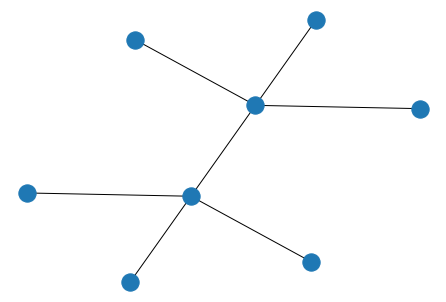

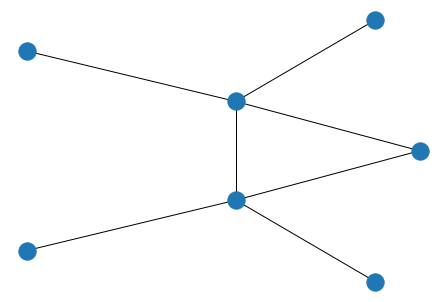

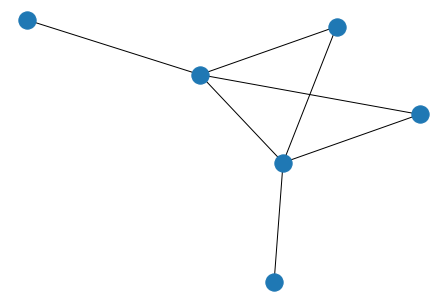

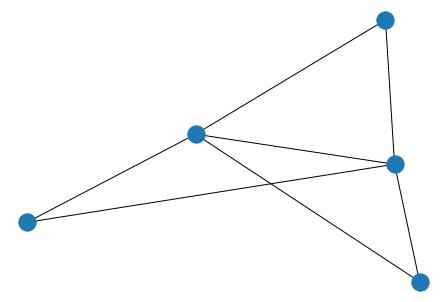

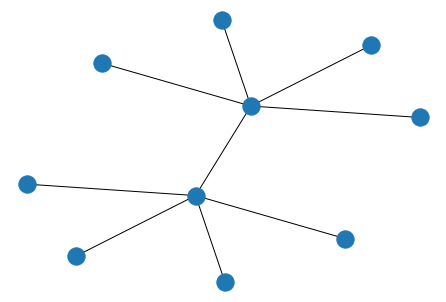

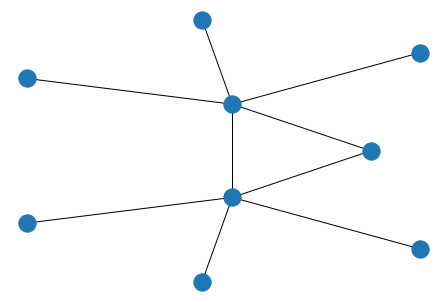

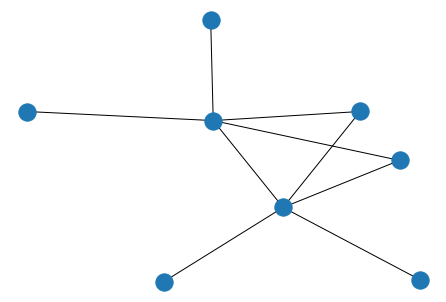

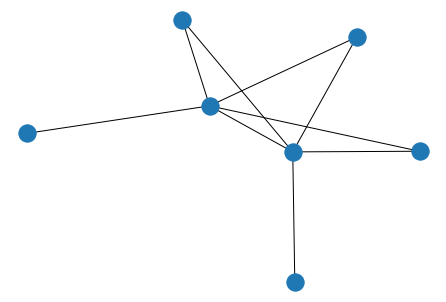

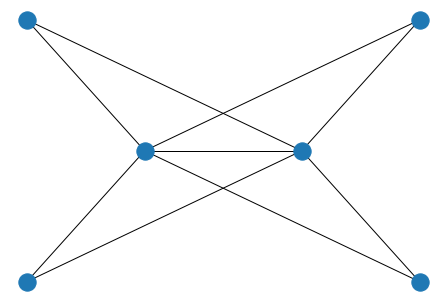

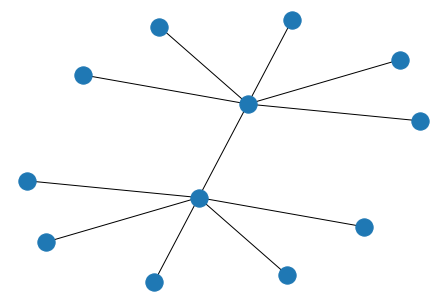

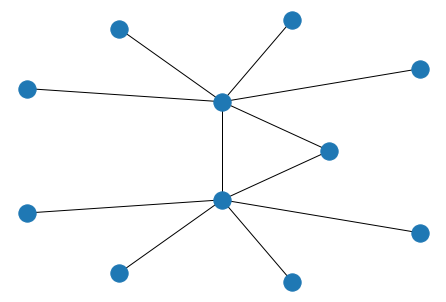

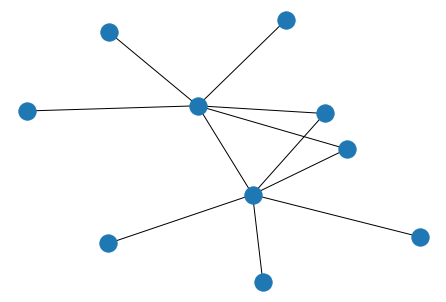

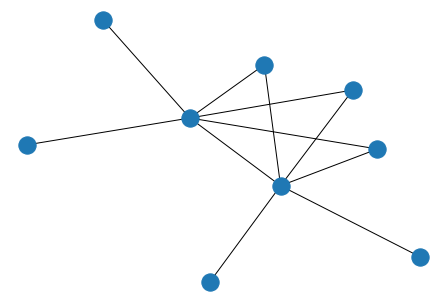

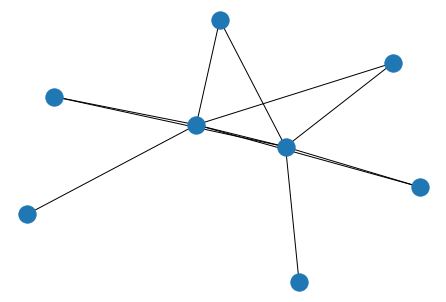

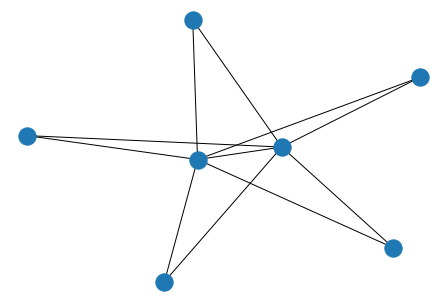

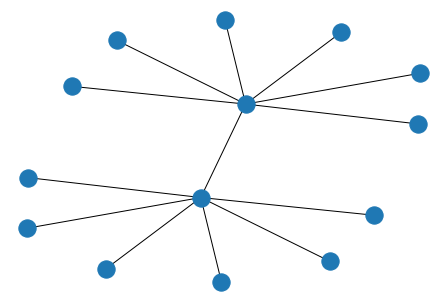

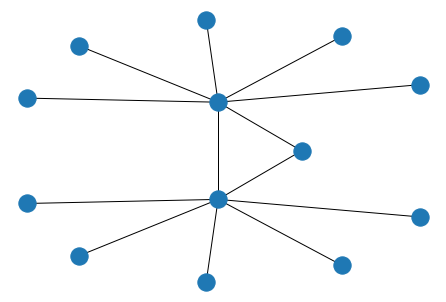

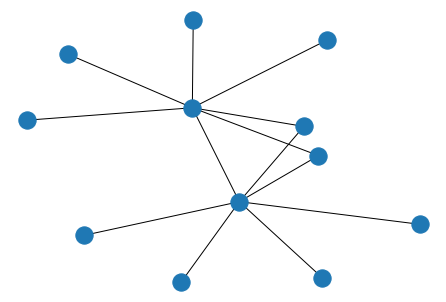

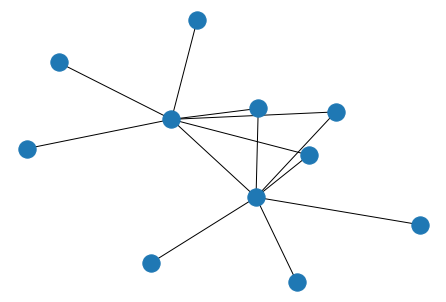

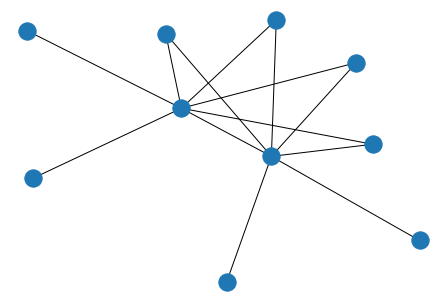

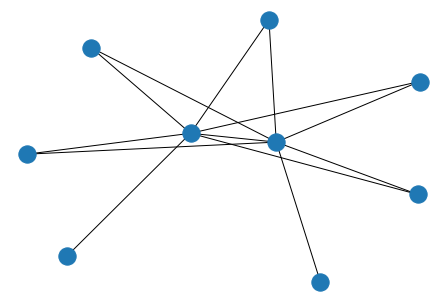

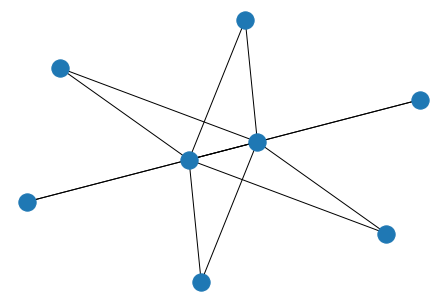

27
27


In [ ]:
d_min = 2
d_max = 7

g_all = []
d_all = []
for d in range(d_min, d_max + 1):
    A = np.zeros((2*d, 2*d))
    A[d + 1:, d] = 1
    A[:d - 1, d - 1] = 1
    A[d - 1, :d - 1] = 1
    A[d, d + 1:] = 1
    A[d, d - 1] = 1
    A[d - 1, d] = 1
    g = nx.from_numpy_matrix(np.array(A))
    #nx.draw_kamada_kawai(g)
    plt.show()
    g_list = [g]
    d_list = [d]
    for i in range(d - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d + 1))
        d_list.append(d)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d - 1, d))
        nx.draw_kamada_kawai(g)
        plt.show()
    g_all += g_list
    d_all += d_list
print(len(g_all))
print(len(d_all))

In [ ]:
def get_qaoa_params(graph, edge, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]


In [ ]:
def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

### Test learning $\gamma \beta$ - my

In [ ]:
gamma, beta = [0.2], [0.7]
test_g = g_all[0]
loss_history, params_history = popt.qaoa_maxcut_torch(test_g, gamma, beta,
                                                      ordering_algo='greedy',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.RMSprop,
                                                      opt_kwargs=dict(lr=0.002),
                                                      steps=100)

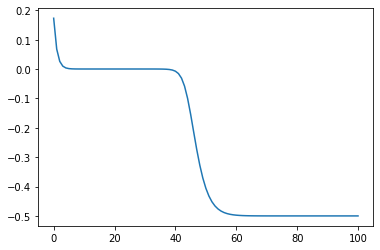

In [ ]:
plt.plot(loss_history)

In [ ]:
def transferrability_matrix(graphs, multistart=20):
    matrix = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=200)
            print('contribution loss', loss, 'params', params)
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2)
                matrix[i,j] += similarity
                if i==j:
                    print(loss, trloss, 'sim', similarity)
                    #assert np.allclose(loss,trloss)
    return matrix

In [ ]:
mat = transferrability_matrix(g_all, multistart=20)

contribution loss -0.5000001 params [array([0.37499994], dtype=float32), array([0.12501466], dtype=float32)]
-0.5000001 -0.49999992305507834 sim 0.3535534055359639


contribution loss -0.50000006 params [array([0.3750001], dtype=float32), array([0.1250039], dtype=float32)]
-0.50000006 -0.4999999309408729 sim 0.3535533872506007



contribution loss -0.50000006 params [array([0.37500384], dtype=float32), array([0.62500006], dtype=float32)]
-0.50000006 -0.4999999309592815 sim 0.35355338725710916



contribution loss -0.5000002 params [array([0.87499994], dtype=float32), array([0.62500143], dtype=float32)]
-0.5000002 -0.4999999314619924 sim 0.3535534295816691



contribution loss -0.5 params [array([0.8750049], dtype=float32), array([0.625], dtype=float32)]
-0.5 -0.49999993059984166 sim 0.3535533660566099


contribution loss -0.5000001 params [array([0.12499999], dtype=float32), array([0.37503812], dtype=float32)]
-0.5000001 -0.49999987418399644 sim 0.3535533882574158



contribution loss -0.50000006 params [array([0.37502074], dtype=float32), array([0.12499999], dtype=float32)]
-0.50000006 -0.4999999145574166 sim 0.35355338145817183



contribution loss -0.49999726 params [array([-0.12499002], dtype=float32), array([0.12473282], dtype=float32)]
-0.49999726 -0.4999971094840588 sim 0.3535513992640347



contribution loss -0.50000006 params [array([0.62499964], dtype=float32), array([0.8749999], dtype=float32)]
-0.50000006 -0.49999993153730954 sim 0.35355338746147297


contribution loss -0.5000001 params [array([0.62497264], dtype=float32), array([0.87500036], dtype=float32)]
-0.5000001 -0.4999999019887032 sim 0.35355339808787095


contribution loss -0.4999866 params [array([0.12444476], dtype=float32), array([0.87482506], dtype=float32)]
-0.4999866 -0.4999865525893145 sim 0.35354389469517306


contribution loss -0.50000006 params [array([0.87499386], dtype=float32), array([0.6250377], dtype=float32)]
-0.50000006 -0.49999987385611666 sim 0.35355336706808205


contribution loss -0.5000001 params [array([0.12499999], dtype=float32), array([0.37500077], dtype=float32)]
-0.5000001 -0.4999999315192146 sim 0.35355340852848977


contribution loss -0.49999997 params [array([0.37501755], dtype=float32), array([0.625], dtype=float32)]
-0.49999997 -0.4999999193785257 sim 0.3535533515525647


contribution loss -0.5 params [array([0.375], dtype=float32), array([0.12500648], dtype=float32)]
-0.5 -0.49999992988417963 sim 0.35355336580358515


contribution loss -0.49999183 params [array([0.87454677], dtype=float32), array([0.62500006], dtype=float32)]
-0.49999183 -0.49999182187753033 sim 0.3535476121312228


contribution loss -0.4999992 params [array([0.12499998], dtype=float32), array([0.8751543], dtype=float32)]
-0.4999992 -0.49999899142169213 sim 0.35355274951574384


contribution loss -0.5000001 params [array([0.87499994], dtype=float32), array([0.12502146], dtype=float32)]
-0.5000001 -0.4999999133656677 sim 0.35355340211023784


contribution loss -0.5000001 params [array([0.12499999], dtype=float32), array([0.37499723], dtype=float32)]
-0.5000001 -0.49999993123965025 sim 0.35355340842964866


contribution loss -0.5000002 params [array([0.8749976], dtype=float32), array([0.62501645], dtype=float32)]
-0.5000002 -0.4999999206344085 sim 0.3535534257535372


contribution loss -0.33333346 params [array([0.4020357], dtype=float32), array([1.0979402], dtype=float32)]
-0.33333346 -0.3333332894437619 sim 0.23570229053727113


contribution loss -0.3333334 params [array([0.9020394], dtype=float32), array([0.5979538], dtype=float32)]
-0.3333334 -0.3333332984646826 sim 0.23570227265323915



contribution loss -0.3333334 params [array([0.5979657], dtype=float32), array([0.4020637], dtype=float32)]
-0.3333334 -0.33333328438355153 sim 0.23570226767480495



contribution loss -0.33333346 params [array([0.0979569], dtype=float32), array([0.9020437], dtype=float32)]
-0.33333346 -0.3333332990999473 sim 0.2357022939512508



contribution loss -0.33333343 params [array([0.0979458], dtype=float32), array([0.9020265], dtype=float32)]
-0.33333343 -0.333333288026909 sim 0.23570227949963304


contribution loss -0.33333346 params [array([0.59795356], dtype=float32), array([0.402041], dtype=float32)]
-0.33333346 -0.33333329870024564 sim 0.23570229380993482



contribution loss -0.33333343 params [array([0.40203896], dtype=float32), array([0.597951], dtype=float32)]
-0.33333343 -0.3333332977367517 sim 0.235702282932583



contribution loss -0.3333334 params [array([0.40204507], dtype=float32), array([0.59795964], dtype=float32)]
-0.3333334 -0.3333332987691845 sim 0.23570227276089686



contribution loss -0.33333343 params [array([0.59796226], dtype=float32), array([0.4020538], dtype=float32)]
-0.33333343 -0.333333295097937 sim 0.23570228199962054


contribution loss -0.3333334 params [array([0.5980021], dtype=float32), array([0.40206495], dtype=float32)]
-0.3333334 -0.33333322502067647 sim 0.23570224668684525


contribution loss -0.3333334 params [array([-0.09793019], dtype=float32), array([0.09796834], dtype=float32)]
-0.3333334 -0.33333327423347897 sim 0.2357022640862104



contribution loss -0.33333346 params [array([0.90200907], dtype=float32), array([0.59792805], dtype=float32)]
-0.33333346 -0.3333332462146669 sim 0.23570227525346465



contribution loss -0.33333343 params [array([0.09795693], dtype=float32), array([0.40204397], dtype=float32)]
-0.33333343 -0.33333329909159803 sim 0.23570228341159377


contribution loss -0.33333343 params [array([0.5979283], dtype=float32), array([0.40201923], dtype=float32)]
-0.33333343 -0.3333332623889962 sim 0.23570227043525557


contribution loss -0.33333346 params [array([0.09795024], dtype=float32), array([0.4020359], dtype=float32)]
-0.33333346 -0.3333332965444748 sim 0.23570229304775414



contribution loss -0.33333352 params [array([0.9020426], dtype=float32), array([1.0979556], dtype=float32)]
-0.33333352 -0.3333332990600408 sim 0.23570231501054764



contribution loss -0.33333346 params [array([0.59795696], dtype=float32), array([0.40204358], dtype=float32)]
-0.33333346 -0.33333329910075093 sim 0.2357022939515349


contribution loss -0.3333334 params [array([0.9020599], dtype=float32), array([0.09797162], dtype=float32)]
-0.3333334 -0.3333332859567052 sim 0.2357022682309991


contribution loss -0.3333334 params [array([0.90203494], dtype=float32), array([1.0979381], dtype=float32)]
-0.3333334 -0.33333328679716256 sim 0.23570226852814577



contribution loss -0.33333343 params [array([1.0979438], dtype=float32), array([0.9020359], dtype=float32)]
-0.33333343 -0.3333332929050571 sim 0.23570228122431994



contribution loss -0.38490024 params [array([0.09795664], dtype=float32), array([0.87499934], dtype=float32)]
-0.38490024 -0.3849001003992611 sim 0.27216552116700743


contribution loss -0.38490018 params [array([0.40202817], dtype=float32), array([0.3750085], dtype=float32)]
-0.38490018 -0.3849000877035309 sim 0.27216549560497233


contribution loss -0.38489664 params [array([0.40200332], dtype=float32), array([0.3753375], dtype=float32)]
-0.38489664 -0.3848965654260516 sim 0.27216299642308645


contribution loss -2.7053328e-08 params [array([0.25], dtype=float32), array([0.5688958], dtype=float32)]
-2.7053328e-08 2.0359479601870692e-32 sim -2.0359479601870692e-32


contribution loss -0.38490027 params [array([0.5979559], dtype=float32), array([0.12499999], dtype=float32)]
-0.38490027 -0.38490010038630756 sim 0.2721655316991333


contribution loss -0.38490015 params [array([0.09797318], dtype=float32), array([0.87499994], dtype=float32)]
-0.38490015 -0.38490008794557184 sim 0.2721654851538379


contribution loss -0.38490015 params [array([0.90204334], dtype=float32), array([0.6250304], dtype=float32)]
-0.38490015 -0.3849000723296445 sim 0.2721654796327723


contribution loss -0.38490018 params [array([0.4020219], dtype=float32), array([-0.12499999], dtype=float32)]
-0.38490018 -0.3849000794442072 sim 0.2721654926848593


contribution loss -0.38490027 params [array([0.5979869], dtype=float32), array([0.6250001], dtype=float32)]
-0.38490027 -0.3849000587304107 sim 0.27216551697153873


contribution loss -0.38490015 params [array([1.0979414], dtype=float32), array([0.8749716], dtype=float32)]
-0.38490015 -0.3849000653621837 sim 0.2721654771694021


contribution loss -0.38490027 params [array([0.59795624], dtype=float32), array([0.12499999], dtype=float32)]
-0.38490027 -0.38490010040510975 sim 0.27216553170578095



contribution loss -0.3849001 params [array([0.59795666], dtype=float32), array([0.62500006], dtype=float32)]
-0.3849001 -0.38490010041220085 sim 0.2721654684880355


contribution loss -0.38490024 params [array([0.09796277], dtype=float32), array([0.8749927], dtype=float32)]
-0.38490024 -0.38490009709299106 sim 0.27216551999806377


contribution loss -0.38490024 params [array([0.4020435], dtype=float32), array([0.8750003], dtype=float32)]
-0.38490024 -0.384900100408861 sim 0.2721655211704015


contribution loss -0.38490024 params [array([0.09795688], dtype=float32), array([0.37500238], dtype=float32)]
-0.38490024 -0.38490010023688603 sim 0.27216552110959913


contribution loss -0.38490018 params [array([1.0979564], dtype=float32), array([0.37500128], dtype=float32)]
-0.38490018 -0.38490010036023087 sim 0.2721655000797931


contribution loss -0.38490024 params [array([0.09797662], dtype=float32), array([0.87499994], dtype=float32)]
-0.38490024 -0.38490008220223426 sim 0.2721655147333831


contribution loss -0.38489693 params [array([0.5980604], dtype=float32), array([0.12529643], dtype=float32)]
-0.38489693 -0.384896939004254 sim 0.27216323387005126


contribution loss -0.38490024 params [array([0.4020587], dtype=float32), array([0.87499994], dtype=float32)]
-0.38490024 -0.3849000897006058 sim 0.27216551738445943


contribution loss -0.38490015 params [array([0.09795664], dtype=float32), array([0.3749713], dtype=float32)]
-0.38490015 -0.3849000753806137 sim 0.2721654807114532


contribution loss -0.29336724 params [array([0.5873381], dtype=float32), array([0.10469657], dtype=float32)]
-0.29336724 -0.29336707745281637 sim 0.20744190620009276


contribution loss -0.29336715 params [array([0.9126662], dtype=float32), array([0.10471541], dtype=float32)]
-0.29336715 -0.2933670675275903 sim 0.20744187108087625


contribution loss -0.29336724 params [array([0.58733815], dtype=float32), array([0.6046972], dtype=float32)]
-0.29336724 -0.2933670774677408 sim 0.20744190620536937


contribution loss -3.2927225e-10 params [array([0.7500007], dtype=float32), array([0.23796897], dtype=float32)]
-3.2927225e-10 1.7039737228195786e-11 sim -1.7016966485075335e-11


contribution loss -0.29336724 params [array([0.4126644], dtype=float32), array([0.89530116], dtype=float32)]
-0.29336724 -0.29336707719793875 sim 0.20744190610997984


contribution loss -0.29336715 params [array([0.08733334], dtype=float32), array([0.39534998], dtype=float32)]
-0.29336715 -0.29336700469063415 sim 0.20744184886464473


contribution loss -0.2933672 params [array([0.08735299], dtype=float32), array([0.89531106], dtype=float32)]
-0.2933672 -0.2933670687729801 sim 0.2074418925946008




contribution loss -0.29336724 params [array([0.58733815], dtype=float32), array([0.6046972], dtype=float32)]
-0.29336724 -0.2933670774677408 sim 0.20744190620536937


contribution loss -0.29336718 params [array([0.08733557], dtype=float32), array([0.39529654], dtype=float32)]
-0.29336718 -0.29336707622771807 sim 0.2074418846935446


contribution loss -0.29336724 params [array([0.41266125], dtype=float32), array([-0.1046951], dtype=float32)]
-0.29336724 -0.2933670773270453 sim 0.20744190615562597


contribution loss -0.29336718 params [array([0.08732232], dtype=float32), array([0.8953032], dtype=float32)]
-0.29336718 -0.2933670681647375 sim 0.20744188184284895


contribution loss -0.29336718 params [array([0.4126656], dtype=float32), array([0.39530057], dtype=float32)]
-0.29336718 -0.29336707690243247 sim 0.20744188493209229


contribution loss 0.0 params [array([0.74999976], dtype=float32), array([0.24785118], dtype=float32)]
0.0 2.1830893105048874e-12 sim 0.0


contribution loss -0.29336727 params [array([0.587335], dtype=float32), array([0.6047092], dtype=float32)]
-0.29336727 -0.29336707313793425 sim 0.20744191521125283


contribution loss -4.2146848e-08 params [array([0.25000036], dtype=float32), array([0.08262866], dtype=float32)]
-4.2146848e-08 5.593218774468282e-12 sim -5.5932187252161296e-12


contribution loss -0.2933606 params [array([0.5877658], dtype=float32), array([0.10465962], dtype=float32)]
-0.2933606 -0.29336052605589613 sim 0.20743724024471322


contribution loss -0.29336724 params [array([0.08734082], dtype=float32), array([-0.104688], dtype=float32)]
-0.29336724 -0.2933670748593857 sim 0.2074419052831758


contribution loss -0.29336715 params [array([0.9126436], dtype=float32), array([0.60469085], dtype=float32)]
-0.29336715 -0.29336706543592966 sim 0.20744187034136224


contribution loss -0.29336715 params [array([0.41266373], dtype=float32), array([0.395302], dtype=float32)]
-0.29336715 -0.29336707733755607 sim 0.20744187454922425


contribution loss -0.29336718 params [array([0.41266245], dtype=float32), array([0.39530253], dtype=float32)]
-0.29336718 -0.29336707745463597 sim 0.2074418851273258


contribution loss -0.23250549 params [array([0.57821155], dtype=float32), array([0.08993974], dtype=float32)]

-0.23250549 -0.23250530653140222 sim 0.1644061421552396


contribution loss 0.0 params [array([0.7499939], dtype=float32), array([0.7853437], dtype=float32)]
0.0 3.403864459522539e-09 sim 0.0


contribution loss -2.5288108e-07 params [array([0.25003076], dtype=float32), array([0.04486956], dtype=float32)]
-2.5288108e-07 2.5738776763514596e-08 sim -2.5606482011049084e-08


contribution loss -0.23249409 params [array([0.92178243], dtype=float32), array([0.58931684], dtype=float32)]

-0.23249409 -0.23249397262032676 sim 0.16439810472018312


contribution loss -0.23250549 params [array([0.92176014], dtype=float32), array([0.0899037], dtype=float32)]
-0.23250549 -0.23250533036007565 sim 0.16440615057995692


contribution loss -0.23250553 params [array([0.57820135], dtype=float32), array([0.08989101], dtype=float32)]
-0.23250553 -0.23250529032173217 sim 0.16440615222929486


contribution loss -2.1073424e-07 params [array([0.25004268], dtype=float32), array([0.53582036], dtype=float32)]
-2.1073424e-07 3.84460537297242e-08 sim -3.782177891479269e-08


contribution loss -0.23250544 params [array([0.5782324], dtype=float32), array([0.5899065], dtype=float32)]
-0.23250544 -0.23250533396867812 sim 0.1644061360507368


contribution loss -0.23250544 params [array([0.42177305], dtype=float32), array([0.91009027], dtype=float32)]
-0.23250544 -0.23250533454372468 sim 0.16440613625404663


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/usr/lib/python3.7/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/usr/lib/python3.7/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/usr/lib/python3.7/_weakrefset.py", line 119, in update
    for element in other:
  File "/usr/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



contribution loss -0.23250553 params [array([0.07822745], dtype=float32), array([0.41009519], dtype=float32)]
-0.23250553 -0.23250533406136412 sim 0.1644061676936118


contribution loss -0.23250549 params [array([0.9217738], dtype=float32), array([0.5898917], dtype=float32)]
-0.23250549 -0.23250532457382558 sim 0.16440614853420651


contribution loss -0.23250549 params [array([0.921772], dtype=float32), array([0.08990923], dtype=float32)]
-0.23250549 -0.23250533457216546 sim 0.16440615206915704


contribution loss -0.23250544 params [array([0.9217825], dtype=float32), array([0.5899282], dtype=float32)]
-0.23250544 -0.23250532347142105 sim 0.1644061323393933


contribution loss -0.23250557 params [array([0.42177284], dtype=float32), array([0.9100909], dtype=float32)]
-0.23250557 -0.23250533456937023 sim 0.1644061836782653


contribution loss -0.23250543 params [array([1.0782276], dtype=float32), array([0.91009116], dtype=float32)]
-0.23250543 -0.23250533458239614 sim 0.16440613099936635


contribution loss -0.23250547 params [array([0.42177165], dtype=float32), array([0.9100918], dtype=float32)]

-0.23250547 -0.23250533457313735 sim 0.16440614680114948


contribution loss 0.0 params [array([0.24998473], dtype=float32), array([0.27347937], dtype=float32)]
0.0 1.534342950130069e-08 sim 0.0


contribution loss -4.2146848e-08 params [array([0.749999], dtype=float32), array([0.1731766], dtype=float32)]
-4.2146848e-08 3.027153909459372e-11 sim -3.027153128653365e-11


contribution loss -0.23250553 params [array([0.57823104], dtype=float32), array([0.5899459], dtype=float32)]
-0.23250553 -0.23250528712928695 sim 0.16440615110059328


contribution loss -0.23250547 params [array([0.07824577], dtype=float32), array([0.41007277], dtype=float32)]
-0.23250547 -0.23250530518633455 sim 0.1644061364113356


contribution loss -0.32475942 params [array([0.08333334], dtype=float32), array([0.8750149], dtype=float32)]
-0.32475942 -0.3247594317971521 sim 0.22963959362686223


contribution loss -0.3247585 params [array([0.4166431], dtype=float32), array([0.6248102], dtype=float32)]
-0.3247585 -0.32475848549711395 sim 0.22963893242119918


contribution loss -0.3247594 params [array([0.5833333], dtype=float32), array([0.37499672], dtype=float32)]
-0.3247594 -0.32475943721522144 sim 0.22963958500572543


contribution loss -0.32475948 params [array([0.5833541], dtype=float32), array([0.87499994], dtype=float32)]
-0.32475948 -0.3247594153424064 sim 0.22963960888265167

















































































































































































































































































































contribution loss -0.32475963 params [array([0.9166617], dtype=float32), array([0.12499999], dtype=float32)]
-0.32475963 -0.32475943621542386 sim 0.22963966894591076


contribution loss -1.890586e-08 params [array([0.75045645], dtype=float32), array([0.43587828], dtype=float32)]
-1.890586e-08 1.7016879047055053e-08 sim -1.2648012644079362e-08


contribution loss -0.32475886 params [array([0.91664755], dtype=float32), array([0.62515974], dtype=float32)]
-0.32475886 -0.32475876445051405 sim 0.22963915748665822


contribution loss -0.32475942 params [array([0.08333333], dtype=float32), array([0.87499934], dtype=float32)]
-0.32475942 -0.3247594374797908 sim 0.22963959563597836


contribution loss -0.32475957 params [array([0.91667473], dtype=float32), array([0.62500095], dtype=float32)]
-0.32475957 -0.3247594341304663 sim 0.2296396471353584


contribution loss -0.32475936 params [array([0.5833333], dtype=float32), array([0.87497544], dtype=float32)]
-0.32475936 -0.32475942202735353 sim 0.2296395690992899


contribution loss -1.582369e-08 params [array([0.74939907], dtype=float32), array([0.04023064], dtype=float32)]
-1.582369e-08 2.6068764364261358e-08 sim -1.3526761825515218e-08









contribution loss -0.32475948 params [array([0.9166666], dtype=float32), array([0.62499964], dtype=float32)]
-0.32475948 -0.3247594374874543 sim 0.22963961671211047


contribution loss -0.32475966 params [array([0.58333915], dtype=float32), array([0.87499994], dtype=float32)]
-0.32475966 -0.32475943575280974 sim 0.22963967931905366


contribution loss -0.3247595 params [array([0.08334495], dtype=float32), array([0.87499994], dtype=float32)]
-0.3247595 -0.3247594305687899 sim 0.22963962480270148


contribution loss -0.32475716 params [array([0.08312129], dtype=float32), array([0.3749933], dtype=float32)]
-0.32475716 -0.32475712936099266 sim 0.2296379788026291


contribution loss -0.3247595 params [array([0.4166655], dtype=float32), array([0.12499999], dtype=float32)]
-0.3247595 -0.324759437420344 sim 0.22963962722509257


contribution loss -0.32475948 params [array([0.08333279], dtype=float32), array([0.87500006], dtype=float32)]
-0.32475948 -0.3247594374756911 sim 0.22963961670795155


contribution loss -0.32475942 params [array([0.08333334], dtype=float32), array([0.3749999], dtype=float32)]
-0.32475942 -0.324759437490605 sim 0.2296395956398017









contribution loss -0.32475942 params [array([0.91666436], dtype=float32), array([1.125], dtype=float32)]
-0.32475942 -0.3247594372184115 sim 0.2296395955435668


contribution loss -0.3247596 params [array([0.5833305], dtype=float32), array([0.875], dtype=float32)]
-0.3247596 -0.32475943708260946 sim 0.22963965871580408


contribution loss -0.26305044 params [array([0.5780265], dtype=float32), array([0.39131263], dtype=float32)]
-0.26305044 -0.2630502054883768 sim 0.18600466593566756


contribution loss -0.26305044 params [array([0.42197183], dtype=float32), array([0.6087035], dtype=float32)]
-0.26305044 -0.2630502125065076 sim 0.18600466841695473


contribution loss -0.2630503 params [array([0.9219689], dtype=float32), array([0.60867006], dtype=float32)]
-0.2630503 -0.26305018325747376 sim 0.18600460539233873


contribution loss -0.26305026 params [array([0.07802921], dtype=float32), array([0.39129668], dtype=float32)]
-0.26305026 -0.2630502123720036 sim 0.18600460514917627


contribution loss -0.2630504 params [array([0.578033], dtype=float32), array([-0.10870213], dtype=float32)]
-0.2630504 -0.26305021116057775 sim 0.1860046574043966


contribution loss -1.0404591e-06 params [array([0.25513616], dtype=float32), array([0.74496686], dtype=float32)]
-1.0404591e-06 -1.040434248429253e-06 sim 7.35706897460968e-07










contribution loss -0.26305014 params [array([0.07802939], dtype=float32), array([0.89137024], dtype=float32)]
-0.26305014 -0.2630500708405339 sim 0.1860045129633942


contribution loss -0.2630503 params [array([0.92195773], dtype=float32), array([0.60869867], dtype=float32)]
-0.2630503 -0.26305020323257094 sim 0.1860046124546059


contribution loss 1.2644054e-07 params [array([0.24891317], dtype=float32), array([0.5530924], dtype=float32)]
1.2644054e-07 1.9726492837505043e-07 sim 1.0645043231238473e-07


contribution loss -0.26305047 params [array([0.57801735], dtype=float32), array([0.39129463], dtype=float32)]
-0.26305047 -0.26305020888776426 sim 0.18600467767423162


contribution loss -0.26305035 params [array([0.5780277], dtype=float32), array([0.39129642], dtype=float32)]
-0.26305035 -0.26305021253865324 sim 0.18600463681821597


contribution loss -0.26305032 params [array([0.07802696], dtype=float32), array([0.89129555], dtype=float32)]
-0.26305032 -0.2630502125448878 sim 0.1860046262837153


contribution loss -0.2630503 params [array([0.92197293], dtype=float32), array([0.10870383], dtype=float32)]
-0.2630503 -0.2630502125572555 sim 0.18600461575138125


contribution loss -0.2630503 params [array([0.92197347], dtype=float32), array([0.10870694], dtype=float32)]
-0.2630503 -0.2630502122925177 sim 0.18600461565778226










contribution loss -0.26305035 params [array([0.57803196], dtype=float32), array([0.8912969], dtype=float32)]
-0.26305035 -0.26305021160896774 sim 0.18600463648952223


contribution loss -0.2630503 params [array([0.07802634], dtype=float32), array([0.8912925], dtype=float32)]
-0.2630503 -0.2630502121919529 sim 0.1860046156222272


contribution loss -0.26305035 params [array([0.42197192], dtype=float32), array([0.60869265], dtype=float32)]
-0.26305035 -0.2630502093812729 sim 0.18600463570191256


contribution loss 1.5805067e-08 params [array([0.75059956], dtype=float32), array([0.7981444], dtype=float32)]
1.5805067e-08 3.0590197007830725e-08 sim 1.4041606630072602e-08


contribution loss -0.2630503 params [array([0.9219723], dtype=float32), array([0.10873668], dtype=float32)]
-0.2630503 -0.2630501841078438 sim 0.18600460569299015


contribution loss -0.2630504 params [array([0.5780277], dtype=float32), array([0.8913008], dtype=float32)]
-0.2630504 -0.263050212021659 sim 0.18600465770883515


contribution loss -8.4293696e-08 params [array([0.24927616], dtype=float32), array([0.52116066], dtype=float32)]
-8.4293696e-08 2.473597756842495e-08 sim -2.3735129316500913e-08


contribution loss -0.21669966 params [array([0.92746484], dtype=float32), array([0.59504646], dtype=float32)]
-0.21669966 -0.2166995611095809 sim 0.15322976404167024










contribution loss -0.2166997 params [array([0.07253366], dtype=float32), array([0.9049505], dtype=float32)]
-0.2166997 -0.21669956139624902 sim 0.1532297799480778


contribution loss -0.21669966 params [array([0.9274652], dtype=float32), array([1.0950449], dtype=float32)]
-0.21669966 -0.21669956080997693 sim 0.1532297639357442


contribution loss -3.6878493e-08 params [array([0.24961738], dtype=float32), array([0.6872518], dtype=float32)]
-3.6878493e-08 9.912148185951737e-09 sim -9.572412305769119e-09


contribution loss -0.21669964 params [array([0.92745245], dtype=float32), array([1.0950402], dtype=float32)]
-0.21669964 -0.21669955437049673 sim 0.15322975639069003


contribution loss -0.2166998 params [array([0.5725033], dtype=float32), array([0.4049237], dtype=float32)]
-0.2166998 -0.21669952353692634 sim 0.15322979817285787


contribution loss -0.2166997 params [array([0.07252897], dtype=float32), array([0.9049599], dtype=float32)]
-0.2166997 -0.2166995576123319 sim 0.15322977861025971


contribution loss -0.21669975 params [array([-0.07253341], dtype=float32), array([0.5950497], dtype=float32)]
-0.21669975 -0.21669956139672544 sim 0.15322979575329632









contribution loss -0.2166997 params [array([0.92746675], dtype=float32), array([0.59505075], dtype=float32)]
-0.2166997 -0.21669956136564686 sim 0.15322977993725828


contribution loss -0.21669966 params [array([0.9274586], dtype=float32), array([0.09506638], dtype=float32)]
-0.21669966 -0.21669954986073325 sim 0.15322976006459912


contribution loss -1.2644054e-07 params [array([0.75055623], dtype=float32), array([0.42155448], dtype=float32)]
-1.2644054e-07 3.5655233116276907e-08 sim -3.431689814307605e-08


contribution loss -0.21669966 params [array([0.07253372], dtype=float32), array([0.40495038], dtype=float32)]
-0.21669966 -0.2166995613959201 sim 0.1532297641429065


contribution loss -0.21669975 params [array([0.5725214], dtype=float32), array([0.40494275], dtype=float32)]
-0.21669975 -0.2166995562795601 sim 0.15322979394410277


contribution loss -0.21669964 params [array([-0.07253119], dtype=float32), array([0.5950512], dtype=float32)]
-0.21669964 -0.21669956120205763 sim 0.153229758806013


contribution loss -0.21669982 params [array([0.42746708], dtype=float32), array([0.5950099], dtype=float32)]
-0.21669982 -0.21669951836263143 sim 0.15322980688015583


contribution loss -0.21669966 params [array([0.07251947], dtype=float32), array([0.40490237], dtype=float32)]
-0.21669966 -0.21669950222956355 sim 0.153229743224422










contribution loss 6.7434956e-07 params [array([0.75163305], dtype=float32), array([0.4421813], dtype=float32)]
6.7434956e-07 7.203650419057635e-07 sim 4.923014537192877e-07


contribution loss 1.6395124e-05 params [array([0.7432177], dtype=float32), array([0.5169397], dtype=float32)]
1.6395124e-05 1.6393870469201802e-05 sim 1.1592660311524314e-05


contribution loss -0.2166998 params [array([0.5725356], dtype=float32), array([0.90492], dtype=float32)]
-0.2166998 -0.21669953540373862 sim 0.15322980236841724


contribution loss -0.18104243 params [array([1.0658149], dtype=float32), array([0.91554916], dtype=float32)]
-0.18104243 -0.18104233311503973 sim 0.12801629666612838


contribution loss -0.18104264 params [array([0.5658159], dtype=float32), array([0.91554993], dtype=float32)]
-0.18104264 -0.18104233312014342 sim 0.12801637042479305


contribution loss -0.18104248 params [array([0.93418616], dtype=float32), array([0.08445294], dtype=float32)]
-0.18104248 -0.18104233295700253 sim 0.12801631241530595


contribution loss -0.18104243 params [array([1.065815], dtype=float32), array([0.41554943], dtype=float32)]
-0.18104243 -0.1810423331192931 sim 0.12801629666763217


contribution loss -0.18104248 params [array([0.06581548], dtype=float32), array([0.91554946], dtype=float32)]
-0.18104248 -0.18104233312673268 sim 0.12801631247531467










contribution loss -0.18104246 params [array([0.06581519], dtype=float32), array([0.9155492], dtype=float32)]
-0.18104246 -0.18104233312324275 sim 0.12801630720573073


contribution loss -0.18104248 params [array([0.06581548], dtype=float32), array([0.9155495], dtype=float32)]
-0.18104248 -0.18104233312696183 sim 0.1280163124753957


contribution loss -0.18104218 params [array([0.06584815], dtype=float32), array([0.4156171], dtype=float32)]
-0.18104218 -0.18104222098747227 sim 0.12801616746100566


contribution loss -0.18104263 params [array([0.56581557], dtype=float32), array([-0.08445035], dtype=float32)]
-0.18104263 -0.1810423331266782 sim 0.12801636515876053


contribution loss -0.18104246 params [array([0.93418497], dtype=float32), array([0.5844506], dtype=float32)]
-0.18104246 -0.18104233312113097 sim 0.12801630720498408


contribution loss -0.18104242 params [array([0.93418765], dtype=float32), array([0.08445625], dtype=float32)]
-0.18104242 -0.18104233227739322 sim 0.12801629110162338


contribution loss -0.18104267 params [array([0.5658134], dtype=float32), array([0.4155479], dtype=float32)]
-0.18104267 -0.18104233298604602 sim 0.12801638091406625


contribution loss -0.18104254 params [array([0.4341825], dtype=float32), array([1.0844477], dtype=float32)]
-0.18104254 -0.1810423329111156 sim 0.1280163334724762










contribution loss -0.18104248 params [array([0.9341731], dtype=float32), array([0.5844505], dtype=float32)]
-0.18104248 -0.18104232866185935 sim 0.12801631089674165


contribution loss -0.18104243 params [array([0.9341824], dtype=float32), array([0.5844467], dtype=float32)]
-0.18104243 -0.1810423327728647 sim 0.12801629654515112


contribution loss -0.18104248 params [array([0.06581548], dtype=float32), array([-0.08445043], dtype=float32)]
-0.18104248 -0.18104233312699966 sim 0.12801631247540907


contribution loss -0.18104242 params [array([0.06581535], dtype=float32), array([0.9155494], dtype=float32)]
-0.18104242 -0.18104233312622672 sim 0.12801629140173154


contribution loss -0.18104269 params [array([0.43418357], dtype=float32), array([0.08444954], dtype=float32)]
-0.18104269 -0.1810423330932212 sim 0.12801638622029946


contribution loss -0.18104246 params [array([0.9341774], dtype=float32), array([0.5844376], dtype=float32)]
-0.18104246 -0.18104232893747493 sim 0.12801630572583667


contribution loss -0.18104248 params [array([0.9341813], dtype=float32), array([0.5844456], dtype=float32)]
-0.18104248 -0.1810423324793436 sim 0.1280163122464278
Treewidth 2









contribution loss -0.28621626 params [array([0.07379503], dtype=float32), array([0.37513167], dtype=float32)]
-0.28621626 -0.28621621079226045 sim 0.20238544058168276


contribution loss -0.28621665 params [array([0.92620796], dtype=float32), array([0.625], dtype=float32)]
-0.28621665 -0.28621660314915653 sim 0.2023857162780518


contribution loss -0.28621677 params [array([0.42620742], dtype=float32), array([0.3750162], dtype=float32)]
-0.28621677 -0.28621659717891784 sim 0.20238575631407763


contribution loss -0.2862166 params [array([0.926208], dtype=float32), array([0.6249999], dtype=float32)]
-0.2862166 -0.2862166031501938 sim 0.20238569520499577


contribution loss -0.2862165 params [array([0.5737184], dtype=float32), array([0.12502915], dtype=float32)]
-0.2862165 -0.2862162796675515 sim 0.20238554922643068


contribution loss -0.2862166 params [array([0.4261971], dtype=float32), array([0.8750625], dtype=float32)]
-0.2862166 -0.2862165078692533 sim 0.20238566151809065


contribution loss -0.2862165 params [array([0.9262011], dtype=float32), array([0.12496116], dtype=float32)]
-0.2862165 -0.2862165662243762 sim 0.20238565053960722


contribution loss -0.28621677 params [array([0.5738098], dtype=float32), array([0.12498202], dtype=float32)]
-0.28621677 -0.28621657755670965 sim 0.20238574937657292










contribution loss -0.2862167 params [array([1.073791], dtype=float32), array([0.375], dtype=float32)]
-0.2862167 -0.28621660311765723 sim 0.20238573734033125


contribution loss -0.2862167 params [array([0.9262098], dtype=float32), array([0.62500095], dtype=float32)]
-0.2862167 -0.28621660298405144 sim 0.20238573729309445


contribution loss -0.2862166 params [array([0.57378715], dtype=float32), array([0.625], dtype=float32)]
-0.2862166 -0.28621660192737763 sim 0.202385694772665


contribution loss -0.28621686 params [array([0.5738126], dtype=float32), array([0.625], dtype=float32)]
-0.28621686 -0.2862165787224218 sim 0.2023857813988128


contribution loss -0.2862168 params [array([0.57379717], dtype=float32), array([0.12500124], dtype=float32)]
-0.2862168 -0.28621660149601125 sim 0.20238576837710417


contribution loss -0.28621665 params [array([1.0737749], dtype=float32), array([0.87499994], dtype=float32)]
-0.28621665 -0.28621658706285963 sim 0.20238571059068544


contribution loss 5.265753e-07 params [array([0.7551697], dtype=float32), array([0.7892207], dtype=float32)]
5.265753e-07 5.260662805498407e-07 sim 3.721648764899522e-07


contribution loss -0.2862167 params [array([0.4262081], dtype=float32), array([0.874995], dtype=float32)]
-0.2862167 -0.2862166025852961 sim 0.2023857371521131










contribution loss -0.28621656 params [array([0.42620203], dtype=float32), array([0.37500483], dtype=float32)]
-0.28621656 -0.2862166004801345 sim 0.20238568372427362


contribution loss -0.28621665 params [array([0.92620796], dtype=float32), array([0.62500113], dtype=float32)]
-0.28621665 -0.286216603120173 sim 0.20238571626780455


contribution loss -0.28621668 params [array([0.57379174], dtype=float32), array([0.62498605], dtype=float32)]
-0.28621668 -0.28621659875574496 sim 0.20238572526145454


contribution loss -0.28621668 params [array([0.57378566], dtype=float32), array([0.12499638], dtype=float32)]
-0.28621668 -0.28621660072164384 sim 0.20238572595650503
Treewidth 3


contribution loss -0.23997307 params [array([0.42936602], dtype=float32), array([0.38908878], dtype=float32)]
-0.23997307 -0.23997297029218115 sim 0.1696865492238991


contribution loss -0.23997506 params [array([0.9293754], dtype=float32), array([1.1111999], dtype=float32)]
-0.23997506 -0.23997490482746942 sim 0.16968793914510433


contribution loss -0.23997515 params [array([0.4293187], dtype=float32), array([0.8887992], dtype=float32)]
-0.23997515 -0.23997505034995686 sim 0.16968802220522594









contribution loss -0.23997515 params [array([0.07068051], dtype=float32), array([0.38878155], dtype=float32)]
-0.23997515 -0.23997504299189523 sim 0.16968801960375657


contribution loss -0.2399751 params [array([0.9293176], dtype=float32), array([0.11120539], dtype=float32)]
-0.2399751 -0.23997504982994677 sim 0.16968800094796008


contribution loss -0.23997512 params [array([1.0706805], dtype=float32), array([0.38879913], dtype=float32)]
-0.23997512 -0.23997505025627738 sim 0.16968801163539896


contribution loss -0.23997512 params [array([0.0706811], dtype=float32), array([0.8887855], dtype=float32)]
-0.23997512 -0.2399750458841366 sim 0.16968801008961304


contribution loss -0.23997481 params [array([0.07062746], dtype=float32), array([0.38886684], dtype=float32)]
-0.23997481 -0.239974798846493 sim 0.16968781211314587


contribution loss -0.23997517 params [array([0.07068223], dtype=float32), array([0.38879952], dtype=float32)]
-0.23997517 -0.23997505038968153 sim 0.16968802748762316


contribution loss -4.2146848e-08 params [array([0.25212616], dtype=float32), array([0.06431279], dtype=float32)]
-4.2146848e-08 2.302413601429878e-08 sim -2.0205739992000577e-08


contribution loss -0.23997511 params [array([0.5706853], dtype=float32), array([0.61119974], dtype=float32)]
-0.23997511 -0.2399750499713354 sim 0.16968800626630287










contribution loss -0.23997506 params [array([0.42931795], dtype=float32), array([0.3888215], dtype=float32)]
-0.23997506 -0.2399750393050746 sim 0.16968798669014523


contribution loss -0.23997512 params [array([0.5706898], dtype=float32), array([0.11119941], dtype=float32)]
-0.23997512 -0.23997504790351756 sim 0.16968801080357238


contribution loss -4.2146848e-08 params [array([0.7464762], dtype=float32), array([0.9742971], dtype=float32)]
-4.2146848e-08 7.623609379472702e-08 sim -3.6885317273217876e-08


contribution loss -0.23997517 params [array([0.5706818], dtype=float32), array([0.11120544], dtype=float32)]
-0.23997517 -0.2399750498260713 sim 0.16968802728835666


contribution loss -0.2399751 params [array([0.42931697], dtype=float32), array([0.8888001], dtype=float32)]
-0.2399751 -0.23997505035733582 sim 0.1696880011344203


contribution loss -0.23997515 params [array([0.07067163], dtype=float32), array([0.8888024], dtype=float32)]
-0.23997515 -0.23997504513375129 sim 0.16968802036101752


contribution loss -4.2146848e-08 params [array([0.75169396], dtype=float32), array([0.97951454], dtype=float32)]
-4.2146848e-08 3.266856623830123e-09 sim -3.257086985928377e-09


contribution loss -0.2399752 params [array([0.5706885], dtype=float32), array([0.6112015], dtype=float32)]
-0.2399752 -0.2399750486296682 sim 0.1696880374020672










contribution loss -0.2399751 params [array([0.9293168], dtype=float32), array([1.1111861], dtype=float32)]
-0.2399751 -0.23997504571437664 sim 0.16968799949288588
Treewidth 4


contribution loss -0.2030155 params [array([0.4327907], dtype=float32), array([0.90114987], dtype=float32)]
-0.2030155 -0.2030152646748886 sim 0.143553555751823


contribution loss -0.20301555 params [array([0.4327907], dtype=float32), array([0.40115213], dtype=float32)]
-0.20301555 -0.20301526480393903 sim 0.1435535716024867


contribution loss -0.20301549 params [array([0.4327907], dtype=float32), array([0.9011523], dtype=float32)]
-0.20301549 -0.20301526480378443 sim 0.14355355052904764


contribution loss -0.20301412 params [array([1.0671024], dtype=float32), array([0.90094936], dtype=float32)]
-0.20301412 -0.2030140922754535 sim 0.14355265128898884


contribution loss -0.2030153 params [array([0.9327869], dtype=float32), array([0.09884598], dtype=float32)]
-0.2030153 -0.20301526440515238 sim 0.14355348189954673


contribution loss -0.20301546 params [array([0.43279025], dtype=float32), array([0.9011523], dtype=float32)]
-0.20301546 -0.20301526481202617 sim 0.14355353999526593


contribution loss -0.20301531 params [array([0.9327924], dtype=float32), array([0.09885204], dtype=float32)]
-0.20301531 -0.20301526428530772 sim 0.1435534871255297










contribution loss -0.20301534 params [array([1.0672069], dtype=float32), array([0.40115163], dtype=float32)]
-0.20301534 -0.20301526451761012 sim 0.14355349774436826


contribution loss -2.5288108e-07 params [array([0.24905188], dtype=float32), array([0.02786521], dtype=float32)]
-2.5288108e-07 4.320267120422281e-10 sim -4.320260815667794e-10


contribution loss -0.20301536 params [array([0.0672099], dtype=float32), array([0.9011525], dtype=float32)]
-0.20301536 -0.2030152648109903 sim 0.14355350311644663


contribution loss -0.20301521 params [array([1.0671889], dtype=float32), array([0.9012136], dtype=float32)]
-0.20301521 -0.20301514814661917 sim 0.14355340918580847


contribution loss -0.20301534 params [array([0.56721574], dtype=float32), array([0.09884531], dtype=float32)]
-0.20301534 -0.20301526356127855 sim 0.1435534974062538


contribution loss -0.2030155 params [array([0.4327907], dtype=float32), array([0.40116957], dtype=float32)]
-0.2030155 -0.20301525766842587 sim 0.14355355327465982


contribution loss -0.20301536 params [array([0.9327863], dtype=float32), array([1.0988363], dtype=float32)]
-0.20301536 -0.20301526162358396 sim 0.14355350198952757









contribution loss -0.20301397 params [array([0.9327976], dtype=float32), array([0.09860766], dtype=float32)]
-0.20301397 -0.20301388213817934 sim 0.14355252431067303


contribution loss -0.2030153 params [array([0.93278354], dtype=float32), array([0.5988441], dtype=float32)]
-0.2030153 -0.20301526316588958 sim 0.14355348146140104


contribution loss -0.20301536 params [array([0.93278974], dtype=float32), array([0.09884754], dtype=float32)]
-0.20301536 -0.20301526480437707 sim 0.1435535031141085


contribution loss -0.2030153 params [array([0.06722245], dtype=float32), array([0.9012143], dtype=float32)]
-0.2030153 -0.20301517569564037 sim 0.14355345053598


contribution loss -0.2030155 params [array([0.43279025], dtype=float32), array([0.90115196], dtype=float32)]
-0.2030155 -0.20301526480928797 sim 0.1435535557993404


contribution loss -0.2030156 params [array([0.4327947], dtype=float32), array([0.9011357], dtype=float32)]
-0.2030156 -0.2030152582802698 sim 0.14355358510104776
Treewidth 4


contribution loss -8.4293696e-08 params [array([0.25003806], dtype=float32), array([0.53393126], dtype=float32)]
-8.4293696e-08 2.5598319120731e-09 sim -2.5586523687300776e-09


contribution loss 0.0 params [array([0.7499909], dtype=float32), array([0.6963664], dtype=float32)]
0.0 2.9242909818254435e-09 sim 0.0










contribution loss 0.0 params [array([0.7500224], dtype=float32), array([0.13649037], dtype=float32)]
0.0 1.1340969107755821e-08 sim 0.0


contribution loss -3.951267e-09 params [array([0.7499996], dtype=float32), array([0.21908958], dtype=float32)]
-3.951267e-09 6.616531423441116e-12 sim -6.616522146869467e-12


contribution loss -2.3349354e-05 params [array([0.7768562], dtype=float32), array([0.50432795], dtype=float32)]
-2.3349354e-05 -2.3444569715869002e-05 sim 1.654404756850389e-05


contribution loss -0.1731207 params [array([0.5625998], dtype=float32), array([0.5884062], dtype=float32)]
-0.1731207 -0.17312036232783487 sim 0.12241470412000546


contribution loss -0.17312045 params [array([0.06259654], dtype=float32), array([0.411595], dtype=float32)]
-0.17312045 -0.1731203628453718 sim 0.12241461474109887


contribution loss -0.17312045 params [array([-0.0625807], dtype=float32), array([0.5884205], dtype=float32)]
-0.17312045 -0.17312035334100842 sim 0.12241461138079616


contribution loss -0.17312062 params [array([0.43740323], dtype=float32), array([0.91159445], dtype=float32)]
-0.17312062 -0.1731203628363938 sim 0.12241467268975445









contribution loss -0.17308606 params [array([0.5636587], dtype=float32), array([0.587914], dtype=float32)]
-0.17308606 -0.17308574104267144 sim 0.12239021471942514


contribution loss -1.2644054e-07 params [array([0.25346005], dtype=float32), array([0.50090855], dtype=float32)]
-1.2644054e-07 1.79268226914333e-08 sim -1.7749314134193203e-08


contribution loss -8.4293696e-08 params [array([0.74995357], dtype=float32), array([0.92329764], dtype=float32)]
-8.4293696e-08 1.8284555769787012e-08 sim -1.786900110790811e-08


contribution loss -0.17312062 params [array([0.43741068], dtype=float32), array([0.4115736], dtype=float32)]
-0.17312062 -0.17312035293825304 sim 0.12241466919022535


contribution loss -1.2644054e-07 params [array([0.24999997], dtype=float32), array([0.44118664], dtype=float32)]
-1.2644054e-07 4.553268052257083e-15 sim -4.55326805225708e-15


contribution loss -2.1073424e-08 params [array([0.7500099], dtype=float32), array([0.61503583], dtype=float32)]
-2.1073424e-08 1.691104362071448e-09 sim -1.6856853561627116e-09


contribution loss -6.322027e-08 params [array([0.7499995], dtype=float32), array([0.59649986], dtype=float32)]
-6.322027e-08 2.9147588427280534e-12 sim -2.9147588396301687e-12









contribution loss -2.1073424e-07 params [array([0.75003827], dtype=float32), array([0.9115895], dtype=float32)]
-2.1073424e-07 1.6077447242145437e-08 sim -1.6030860726695305e-08


contribution loss -0.17312066 params [array([0.5625896], dtype=float32), array([0.58842325], dtype=float32)]
-0.17312066 -0.1731203556283666 sim 0.1224146859463555


contribution loss -0.17312062 params [array([0.5626325], dtype=float32), array([0.5883791], dtype=float32)]
-0.17312062 -0.17312031741135223 sim 0.12241465662953833


contribution loss -8.4293696e-08 params [array([0.25000402], dtype=float32), array([0.42511103], dtype=float32)]
-8.4293696e-08 1.3135024312824301e-10 sim -1.3135008366093333e-10
Treewidth 4


contribution loss -0.14922518 params [array([0.94255257], dtype=float32), array([0.5802187], dtype=float32)]
-0.14922518 -0.14922504235886375 sim 0.10551808640509455


contribution loss -0.14922515 params [array([-0.05741015], dtype=float32), array([0.5802372], dtype=float32)]
-0.14922515 -0.14922499978815773 sim 0.10551806081735864


contribution loss -0.14922538 params [array([-0.05744751], dtype=float32), array([0.08020999], dtype=float32)]
-0.14922538 -0.14922504087615135 sim 0.10551815963768367


contribution loss -0.14922534 params [array([0.05744751], dtype=float32), array([0.41978157], dtype=float32)]
-0.14922534 -0.14922504236982304 sim 0.10551814436076072










contribution loss -0.14922513 params [array([0.05744777], dtype=float32), array([0.919782], dtype=float32)]
-0.14922513 -0.14922504238433368 sim 0.10551807060904891


contribution loss -4.0039507e-07 params [array([0.25000885], dtype=float32), array([0.07067923], dtype=float32)]
-4.0039507e-07 2.283684290679732e-09 sim -2.2836471465517847e-09


contribution loss 0.0 params [array([0.24998981], dtype=float32), array([0.70506626], dtype=float32)]
0.0 1.513161194253742e-08 sim 0.0


contribution loss -0.1492251 params [array([0.9425783], dtype=float32), array([0.58019143], dtype=float32)]
-0.1492251 -0.14922498395320313 sim 0.10551803941380201


contribution loss -0.14922549 params [array([0.5574478], dtype=float32), array([0.08021794], dtype=float32)]
-0.14922549 -0.14922504238610956 sim 0.10551819704988284


contribution loss -0.14922519 params [array([0.05746271], dtype=float32), array([0.9197968], dtype=float32)]
-0.14922519 -0.14922503469187887 sim 0.10551808896275053


contribution loss -1.0536712e-08 params [array([0.25], dtype=float32), array([0.6522666], dtype=float32)]
-1.0536712e-08 0.0 sim -0.0


contribution loss 0.0 params [array([0.25000826], dtype=float32), array([0.30767524], dtype=float32)]
0.0 9.40920690483504e-09 sim 0.0










contribution loss -0.14922515 params [array([0.44256282], dtype=float32), array([0.41977596], dtype=float32)]
-0.14922515 -0.1492250388550766 sim 0.10551807462961778


contribution loss -0.14922519 params [array([0.0574474], dtype=float32), array([0.91978127], dtype=float32)]
-0.14922519 -0.1492250423555625 sim 0.10551809167227601


contribution loss -0.1492254 params [array([0.44255227], dtype=float32), array([0.41978315], dtype=float32)]
-0.1492254 -0.14922504237426817 sim 0.10551816543568736


contribution loss -0.14922515 params [array([0.44254985], dtype=float32), array([-0.08021586], dtype=float32)]
-0.14922515 -0.1492250422502049 sim 0.10551807582997817


contribution loss -2.9502795e-07 params [array([0.7661923], dtype=float32), array([0.99988735], dtype=float32)]
-2.9502795e-07 1.6989129537905866e-07 sim -1.472258455083461e-07


contribution loss -0.14922513 params [array([0.05747801], dtype=float32), array([0.9198148], dtype=float32)]
-0.14922513 -0.1492250077103462 sim 0.10551805834993007


contribution loss 0.0 params [array([0.75], dtype=float32), array([0.8981484], dtype=float32)]
0.0 0.0 sim nan


contribution loss -0.14922549 params [array([0.5574478], dtype=float32), array([0.58021784], dtype=float32)]
-0.14922549 -0.14922504238763495 sim 0.10551819705042215
Treewidth 2










contribution loss -6.7165056e-06 params [array([0.2275672], dtype=float32), array([0.7598917], dtype=float32)]
-6.7165056e-06 -6.7166879175663894e-06 sim 4.749351111639483e-06


contribution loss -0.25880414 params [array([0.5669301], dtype=float32), array([0.8749866], dtype=float32)]
-0.25880414 -0.25880405408538254 sim 0.18300213289283027


contribution loss -0.2588042 params [array([0.43306756], dtype=float32), array([0.62500036], dtype=float32)]
-0.2588042 -0.2588040574276013 sim 0.18300215514789386





contribution loss -2.5885267e-08 params [array([0.750883], dtype=float32), array([0.08254552], dtype=float32)]
-2.5885267e-08 -4.5254136035327105e-12 sim 4.525413534375173e-12


contribution loss -1.5107835e-08 params [array([0.2468101], dtype=float32), array([0.6559535], dtype=float32)]
-1.5107835e-08 2.9911508361861725e-09 sim -2.9341952328418387e-09


contribution loss -0.25880414 params [array([0.06693515], dtype=float32), array([0.8749898], dtype=float32)]
-0.25880414 -0.2588040540845821 sim 0.18300213289254727





contribution loss -0.25880405 params [array([0.5669305], dtype=float32), array([0.3749572], dtype=float32)]
-0.25880405 -0.25880402032721833 sim 0.1830020893473874


contribution loss -0.25880405 params [array([0.5669305], dtype=float32), array([0.37495676], dtype=float32)]
-0.25880405 -0.2588040195412608 sim 0.18300208906950938


contribution loss -0.25880405 params [array([0.43306985], dtype=float32), array([1.1249999], dtype=float32)]
-0.25880405 -0.2588040577602914 sim 0.18300210258197835





contribution loss -0.2588043 params [array([0.43306965], dtype=float32), array([0.6249662], dtype=float32)]
-0.2588043 -0.2588040344179648 sim 0.18300217862284895


contribution loss -0.2588043 params [array([0.5669303], dtype=float32), array([0.375], dtype=float32)]
-0.2588043 -0.2588040577587307 sim 0.18300218687506764


contribution loss -0.2588021 params [array([0.93325067], dtype=float32), array([0.6250396], dtype=float32)]
-0.2588021 -0.2588020208442802 sim 0.18300068700041144


contribution loss 1.8505368e-07 params [array([0.24033532], dtype=float32), array([0.02484068], dtype=float32)]
1.8505368e-07 2.523473644873006e-07 sim 1.4922850877725054e-07






contribution loss -0.2588041 params [array([0.06692842], dtype=float32), array([0.8749999], dtype=float32)]
-0.2588041 -0.25880405758281194 sim 0.18300212359265106


contribution loss -0.25880423 params [array([0.43307537], dtype=float32), array([0.12499877], dtype=float32)]
-0.25880423 -0.2588040558843105 sim 0.18300216513895998


contribution loss -0.25880414 params [array([0.9330672], dtype=float32), array([0.6250036], dtype=float32)]
-0.25880414 -0.25880405705922893 sim 0.18300213394424428





contribution loss -0.25880414 params [array([0.9330533], dtype=float32), array([0.6249943], dtype=float32)]
-0.25880414 -0.258804040266811 sim 0.1830021280072247


contribution loss -0.25880414 params [array([0.5669301], dtype=float32), array([0.3750003], dtype=float32)]
-0.25880414 -0.2588040577588106 sim 0.18300213419158387


contribution loss -0.258804 params [array([0.06693012], dtype=float32), array([0.3750179], dtype=float32)]
-0.258804 -0.25880405120506306 sim 0.18300207919092748





contribution loss -0.25880402 params [array([0.9330698], dtype=float32), array([0.624956], dtype=float32)]
-0.25880402 -0.2588040182206961 sim 0.18300207806590824
Treewidth 3


contribution loss -0.22191249 params [array([0.43509656], dtype=float32), array([0.11292614], dtype=float32)]
-0.22191249 -0.22191241266758044 sim 0.15691579858141805


contribution loss -0.22191253 params [array([0.56490594], dtype=float32), array([0.38711312], dtype=float32)]
-0.22191253 -0.22191244459753928 sim 0.15691582567542894


contribution loss -0.22191253 params [array([0.9350941], dtype=float32), array([1.1128865], dtype=float32)]
-0.22191253 -0.2219124445967971 sim 0.15691582567516657






contribution loss -0.22191255 params [array([0.9350942], dtype=float32), array([0.11288795], dtype=float32)]
-0.22191255 -0.22191244457137965 sim 0.15691583093453276


contribution loss -0.2219125 params [array([0.9350941], dtype=float32), array([0.6128868], dtype=float32)]
-0.2219125 -0.2219124445981343 sim 0.15691581513893244


contribution loss -1.1211061e-05 params [array([0.22770013], dtype=float32), array([-0.01707814], dtype=float32)]
-1.1211061e-05 -1.1201405679793422e-05 sim 7.924001403013631e-06





contribution loss -0.22191258 params [array([0.43509924], dtype=float32), array([0.6129461], dtype=float32)]
-0.22191258 -0.22191237171842798 sim 0.15691581571379884


contribution loss -0.2219112 params [array([0.43509167], dtype=float32), array([0.11313606], dtype=float32)]
-0.2219112 -0.22191115920793672 sim 0.1569149023378937


contribution loss -0.2219124 params [array([0.93513644], dtype=float32), array([0.6128854], dtype=float32)]
-0.2219124 -0.22191235852923558 sim 0.15691574783049117





contribution loss -0.22191264 params [array([0.56490326], dtype=float32), array([0.8871128], dtype=float32)]
-0.22191264 -0.2219124442811621 sim 0.15691586244202999


contribution loss -0.22191264 params [array([0.43509668], dtype=float32), array([0.612887], dtype=float32)]
-0.22191264 -0.22191244429648466 sim 0.15691586244744732


contribution loss -0.2219125 params [array([0.06490596], dtype=float32), array([-0.11288369], dtype=float32)]
-0.2219125 -0.22191244439769026 sim 0.15691581506806473


contribution loss -0.22191253 params [array([0.56490594], dtype=float32), array([-0.11288401], dtype=float32)]




-0.22191253 -0.22191244443677188 sim 0.15691582561858905


contribution loss -0.22191247 params [array([0.56490576], dtype=float32), array([0.8871646], dtype=float32)]
-0.22191247 -0.22191239002286456 sim 0.15691578530694444


contribution loss -0.22191262 params [array([0.5649234], dtype=float32), array([0.3871154], dtype=float32)]
-0.22191262 -0.22191242977755304 sim 0.15691585204587394


contribution loss -0.2219125 params [array([0.9350941], dtype=float32), array([0.6128868], dtype=float32)]
-0.2219125 -0.2219124445981343 sim 0.15691581513893244





contribution loss -0.22191258 params [array([0.56490785], dtype=float32), array([0.8871483], dtype=float32)]
-0.22191258 -0.22191241914059834 sim 0.15691583248008864


contribution loss -0.22191247 params [array([0.06487401], dtype=float32), array([0.3871133], dtype=float32)]
-0.22191247 -0.2219123959340853 sim 0.15691578739687773


contribution loss -0.22191249 params [array([0.43509394], dtype=float32), array([0.11290085], dtype=float32)]
-0.22191249 -0.22191244051502348 sim 0.15691580842698008





contribution loss -4.2146848e-08 params [array([0.7557899], dtype=float32), array([0.47077167], dtype=float32)]
-4.2146848e-08 2.2839459858358043e-08 sim -2.0080574435972003e-08
Treewidth 4


contribution loss -0.19132385 params [array([0.4374208], dtype=float32), array([0.6016652], dtype=float32)]
-0.19132385 -0.19132364681390854 sim 0.1352863186908827


contribution loss -0.19132389 params [array([0.43741068], dtype=float32), array([0.6016972], dtype=float32)]
-0.19132389 -0.19132361332430448 sim 0.13528632265553606


contribution loss -0.19132374 params [array([0.06257625], dtype=float32), array([0.89833546], dtype=float32)]
-0.19132374 -0.19132364769872548 sim 0.13528628212526322


contribution loss -0.19132385 params [array([0.56257415], dtype=float32), array([0.8983351], dtype=float32)]
-0.19132385 -0.19132364790528125 sim 0.1352863190767418


contribution loss -0.19132355 params [array([0.5625731], dtype=float32), array([0.39841923], dtype=float32)]
-0.19132355 -0.19132349662956405 sim 0.13528616022562878


contribution loss -0.19132389 params [array([0.06257163], dtype=float32), array([0.8983351], dtype=float32)]
-0.19132389 -0.19132364770669952 sim 0.13528633481157326


contribution loss -0.19132385 params [array([0.4374232], dtype=float32), array([0.601642], dtype=float32)]
-0.19132385 -0.19132363680791495 sim 0.13528631515322406










contribution loss -0.19132385 params [array([0.43743291], dtype=float32), array([0.60167223], dtype=float32)]
-0.19132385 -0.1913236453459235 sim 0.13528631817187078


contribution loss -0.19132386 params [array([0.5625715], dtype=float32), array([0.3983236], dtype=float32)]
-0.19132386 -0.1913236451150412 sim 0.1352863233585889


contribution loss -0.19132364 params [array([0.9374213], dtype=float32), array([0.10171749], dtype=float32)]
-0.19132364 -0.1913235867701628 sim 0.13528622370527962


contribution loss -0.19132371 params [array([0.06259533], dtype=float32), array([0.89833546], dtype=float32)]
-0.19132371 -0.19132363029773028 sim 0.13528626543637323


contribution loss -0.19132397 params [array([0.43742564], dtype=float32), array([1.1016611], dtype=float32)]
-0.19132397 -0.19132364758548473 sim 0.13528636111043957


contribution loss -0.19132371 params [array([-0.06257216], dtype=float32), array([0.6016614], dtype=float32)]
-0.19132371 -0.19132364746838884 sim 0.13528627150712133


contribution loss -0.19132368 params [array([0.93742555], dtype=float32), array([0.10168478], dtype=float32)]
-0.19132368 -0.19132363951506393 sim 0.13528625815848747


contribution loss -0.19132376 params [array([0.9374223], dtype=float32), array([0.10166433], dtype=float32)]
-0.19132376 -0.1913236473536282 sim 0.13528628727160463










contribution loss -0.19132374 params [array([0.9374261], dtype=float32), array([0.10166507], dtype=float32)]
-0.19132374 -0.1913236479075414 sim 0.13528628219909086


contribution loss -0.19132395 params [array([0.4374232], dtype=float32), array([0.10166985], dtype=float32)]
-0.19132395 -0.1913236469900922 sim 0.13528635563159278


contribution loss -0.19132394 params [array([0.562572], dtype=float32), array([0.3983258], dtype=float32)]
-0.19132394 -0.19132364609249788 sim 0.13528635004590073


contribution loss -0.19132371 params [array([0.4374275], dtype=float32), array([0.6016743], dtype=float32)]
-0.19132371 -0.19132364607909885 sim 0.13528627101593285


contribution loss -0.19132376 params [array([0.06257202], dtype=float32), array([0.89832], dtype=float32)]
-0.19132376 -0.19132364319948117 sim 0.1352862858028906
Treewidth 4


contribution loss 2.0851165e-07 params [array([0.25340265], dtype=float32), array([0.75633246], dtype=float32)]
2.0851165e-07 2.0859923198918497e-07 sim 1.474709570445591e-07


contribution loss -0.16578694 params [array([0.44061518], dtype=float32), array([0.59167606], dtype=float32)]
-0.16578694 -0.16578663615413597 sim 0.11722896097690293


contribution loss 5.564701e-08 params [array([0.74754906], dtype=float32), array([0.7351171], dtype=float32)]








5.564701e-08 5.586305922873431e-08 sim 3.942454126682524e-08


contribution loss -0.16578703 params [array([0.44063002], dtype=float32), array([0.09168797], dtype=float32)]
-0.16578703 -0.16578664716883373 sim 0.1172289964812378


contribution loss -3.0767198e-05 params [array([0.21735065], dtype=float32), array([-0.00804626], dtype=float32)]
-3.0767198e-05 -3.077003595384497e-05 sim 2.175669765714807e-05


contribution loss -0.16578676 params [array([-0.05936575], dtype=float32), array([0.09168937], dtype=float32)]
-0.16578676 -0.16578664728212517 sim 0.11722890169109348


contribution loss -0.16578671 params [array([0.05934733], dtype=float32), array([0.40831283], dtype=float32)]
-0.16578671 -0.1657866330892737 sim 0.11722888086810386


contribution loss -0.16578703 params [array([0.4406331], dtype=float32), array([0.09168918], dtype=float32)]
-0.16578703 -0.16578664736673615 sim 0.11722899655120712


contribution loss -0.16578676 params [array([0.9406241], dtype=float32), array([0.09167897], dtype=float32)]
-0.16578676 -0.1657866438013039 sim 0.11722890046043606


contribution loss -0.16578692 params [array([0.5593379], dtype=float32), array([0.9082945], dtype=float32)]
-0.16578692 -0.16578661743226314 sim 0.11722894908936154


contribution loss -0.16578698 params [array([0.4406328], dtype=float32), array([0.09168605], dtype=float32)]
-0.16578698 -0.16578664719172592 sim 0.11722898068431427










contribution loss -0.16578673 params [array([0.5593664], dtype=float32), array([0.4083081], dtype=float32)]
-0.16578673 -0.16578664717310596 sim 0.11722889111584638


contribution loss -0.16578671 params [array([0.05936709], dtype=float32), array([0.4083102], dtype=float32)]
-0.16578671 -0.16578664735732904 sim 0.11722888591262653


contribution loss -3.3717478e-07 params [array([0.25510913], dtype=float32), array([0.9823337], dtype=float32)]
-3.3717478e-07 2.047757884121355e-08 sim -2.043991745810818e-08


contribution loss -0.16578673 params [array([0.05936679], dtype=float32), array([0.9083086], dtype=float32)]
-0.16578673 -0.16578664724291192 sim 0.11722889114052652


contribution loss -0.16578694 params [array([0.5593699], dtype=float32), array([0.908271], dtype=float32)]
-0.16578694 -0.16578661047164395 sim 0.11722895189674504


contribution loss -4.2146848e-08 params [array([0.24875578], dtype=float32), array([0.30489692], dtype=float32)]
-4.2146848e-08 3.288753702042691e-09 sim -3.2787868934682107e-09


contribution loss -0.16578671 params [array([0.05936738], dtype=float32), array([0.40831086], dtype=float32)]
-0.16578671 -0.1657866473753316 sim 0.11722888591899142


contribution loss -0.16578676 params [array([1.059356], dtype=float32), array([0.40830764], dtype=float32)]
-0.16578676 -0.16578664309575086 sim 0.11722890021098516










contribution loss -1.6858739e-07 params [array([0.74704105], dtype=float32), array([0.62001204], dtype=float32)]
-1.6858739e-07 5.8139826178520135e-08 sim -5.496319353204031e-08
Treewidth 4


contribution loss -0.14465882 params [array([0.5554388], dtype=float32), array([0.4166308], dtype=float32)]
-0.14465882 -0.14465837871715595 sim 0.10228907615326811


contribution loss -2.2548564e-05 params [array([0.7110854], dtype=float32), array([0.49749303], dtype=float32)]
-2.2548564e-05 -2.2552875571778062e-05 sim 1.5945766563696214e-05


contribution loss 2.7171545e-06 params [array([0.24537927], dtype=float32), array([0.2823455], dtype=float32)]
2.7171545e-06 2.7096515578697165e-06 sim 1.918660191059094e-06


contribution loss -0.14465849 params [array([0.9445605], dtype=float32), array([0.58336824], dtype=float32)]
-0.14465849 -0.14465837875215148 sim 0.10228896026213948


contribution loss -2.1073424e-08 params [array([0.74873537], dtype=float32), array([0.6297799], dtype=float32)]
-2.1073424e-08 8.480961782516038e-09 sim -7.867715808979077e-09


contribution loss -0.14465827 params [array([0.94457424], dtype=float32), array([0.5834611], dtype=float32)]
-0.14465827 -0.14465819841762814 sim 0.10228881747893069


contribution loss -0.14465877 params [array([0.44456533], dtype=float32), array([0.5833793], dtype=float32)]
-0.14465877 -0.14465837603917378 sim 0.1022890594014548










contribution loss -0.14465848 params [array([0.0554396], dtype=float32), array([0.9166318], dtype=float32)]
-0.14465848 -0.14465837875300297 sim 0.10228895499409017


contribution loss -0.14465283 params [array([0.44452453], dtype=float32), array([0.5838474], dtype=float32)]
-0.14465283 -0.14465276931797247 sim 0.10228497505237856


contribution loss -1.8966081e-07 params [array([0.24746889], dtype=float32), array([0.10436111], dtype=float32)]
-1.8966081e-07 9.602089439337748e-08 sim -8.566752948732216e-08


contribution loss -0.14465852 params [array([1.055439], dtype=float32), array([0.41663158], dtype=float32)]
-0.14465852 -0.14465837874049878 sim 0.10228897079471784


contribution loss -0.0032072065 params [array([0.32588032], dtype=float32), array([0.5228362], dtype=float32)]
-0.0032072065 -0.0032071948590630187 sim 0.002267833346722886


contribution loss -0.1446514 params [array([0.9449351], dtype=float32), array([0.08316893], dtype=float32)]
-0.1446514 -0.1446512859336362 sim 0.10228394483461818


contribution loss -0.14465873 params [array([0.05543917], dtype=float32), array([0.91663104], dtype=float32)]
-0.14465873 -0.14465837873442025 sim 0.1022890445493652


contribution loss 1.0115243e-06 params [array([0.7537668], dtype=float32), array([0.17728578], dtype=float32)]
1.0115243e-06 1.002847343014253e-06 sim 7.121681092534564e-07










contribution loss -2.1073424e-08 params [array([0.2507259], dtype=float32), array([0.30248109], dtype=float32)]
-2.1073424e-08 1.5505174516153267e-09 sim -1.5463375041416322e-09


contribution loss -0.14465873 params [array([0.44455755], dtype=float32), array([1.0833666], dtype=float32)]
-0.14465873 -0.14465837851184615 sim 0.1022890444706731


contribution loss 1.3803093e-06 params [array([0.75436926], dtype=float32), array([0.65350896], dtype=float32)]
1.3803093e-06 1.5155119541295565e-06 sim 1.0204839846307307e-06


contribution loss -4.6361532e-07 params [array([0.25154135], dtype=float32), array([0.5726257], dtype=float32)]
-4.6361532e-07 6.762521875692865e-09 sim -6.761802573810951e-09


contribution loss 1.7701676e-06 params [array([0.25723583], dtype=float32), array([0.44299954], dtype=float32)]
1.7701676e-06 2.2112382523482076e-06 sim 1.381909789090471e-06
Treewidth 4


contribution loss -0.12738682 params [array([0.4486121], dtype=float32), array([0.07673726], dtype=float32)]
-0.12738682 -0.12738632148930887 sim 0.09007590917062619


contribution loss -0.12738645 params [array([0.9486265], dtype=float32), array([0.57675624], dtype=float32)]
-0.12738645 -0.12738633052386752 sim 0.09007578065641753









contribution loss -0.12738647 params [array([0.05137312], dtype=float32), array([0.92324334], dtype=float32)]
-0.12738647 -0.1273863305165088 sim 0.09007578592216396


contribution loss -0.0023254524 params [array([0.16124102], dtype=float32), array([-0.0086938], dtype=float32)]
-0.0023254524 -0.002325681280306711 sim 0.0016444240762745464


contribution loss -0.12738651 params [array([0.9486358], dtype=float32), array([0.07676943], dtype=float32)]
-0.12738651 -0.12738632629513988 sim 0.09007580023472032


contribution loss -0.12738645 params [array([0.05137325], dtype=float32), array([0.9232435], dtype=float32)]
-0.12738645 -0.127386330520719 sim 0.09007578065530435


contribution loss -0.12738666 params [array([0.44857115], dtype=float32), array([0.07668379], dtype=float32)]
-0.12738666 -0.1273861969076067 sim 0.09007580717250524


contribution loss -0.12738645 params [array([0.05137425], dtype=float32), array([0.923245], dtype=float32)]
-0.12738645 -0.12738633049807768 sim 0.09007578064729942


contribution loss -0.1273856 params [array([0.44852272], dtype=float32), array([1.0765597], dtype=float32)]
-0.1273856 -0.12738554752487297 sim 0.09007520352819658


contribution loss -0.12738681 params [array([0.5513737], dtype=float32), array([0.92324424], dtype=float32)]
-0.12738681 -0.1273863305226597 sim 0.09007590709609076










contribution loss -0.12738672 params [array([0.55141467], dtype=float32), array([-0.07675823], dtype=float32)]
-0.12738672 -0.1273862657844335 sim 0.09007585259758281


contribution loss -0.12738682 params [array([0.44861987], dtype=float32), array([0.07674687], dtype=float32)]
-0.12738682 -0.1273863284791664 sim 0.09007591164192853


contribution loss -0.12738645 params [array([0.05137302], dtype=float32), array([0.92324334], dtype=float32)]
-0.12738645 -0.12738633051477363 sim 0.09007578065320235


contribution loss -0.00337356 params [array([0.15712929], dtype=float32), array([-0.01043295], dtype=float32)]
-0.00337356 -0.0033736212050438 sim 0.002385488802307606


contribution loss -0.12738647 params [array([0.05138234], dtype=float32), array([0.42325664], dtype=float32)]
-0.12738647 -0.12738632672782593 sim 0.0900757845826601


contribution loss -0.12738681 params [array([0.55137455], dtype=float32), array([-0.07675426], dtype=float32)]
-0.12738681 -0.12738633045699993 sim 0.09007590707287641


contribution loss -0.12738645 params [array([0.05136393], dtype=float32), array([0.42323244], dtype=float32)]
-0.12738645 -0.12738632683974688 sim 0.0900757793538823


contribution loss -0.12738645 params [array([0.9486265], dtype=float32), array([0.57675624], dtype=float32)]
-0.12738645 -0.12738633052386752 sim 0.09007578065641753










contribution loss -0.09034792 params [array([0.58453304], dtype=float32), array([0.45619315], dtype=float32)]
-0.09034792 -0.09034791010247235 sim 0.06388562457910205


contribution loss -0.12738648 params [array([1.0513725], dtype=float32), array([0.9232432], dtype=float32)]
-0.12738648 -0.12738633049540243 sim 0.09007579118304893
Treewidth 2


contribution loss -0.23801842 params [array([0.93830574], dtype=float32), array([0.12500569], dtype=float32)]
-0.23801842 -0.2380183263367097 sim 0.16830440688771867


contribution loss -0.23801833 params [array([0.9383118], dtype=float32), array([0.12497035], dtype=float32)]
-0.23801833 -0.23801831305647364 sim 0.1683043705823198






contribution loss -0.23801844 params [array([0.56168836], dtype=float32), array([0.6250014], dtype=float32)]
-0.23801844 -0.2380183295382179 sim 0.16830441328797613


contribution loss -0.23801854 params [array([0.56168836], dtype=float32), array([0.12499999], dtype=float32)]
-0.23801854 -0.23801832957353655 sim 0.16830445017891824


contribution loss -0.23801842 params [array([0.06169046], dtype=float32), array([0.37500003], dtype=float32)]
-0.23801842 -0.23801832916542212 sim 0.16830440788782014


contribution loss -1.5137909e-08 params [array([0.75391275], dtype=float32), array([0.83539873], dtype=float32)]




-1.5137909e-08 1.9383007302978422e-10 sim -1.9381418579472182e-10


contribution loss -0.23801841 params [array([0.43831366], dtype=float32), array([0.87500006], dtype=float32)]
-0.23801841 -0.2380183294192864 sim 0.1683044027092216


contribution loss -0.23801832 params [array([0.06168489], dtype=float32), array([0.37500006], dtype=float32)]
-0.23801832 -0.2380183289792185 sim 0.16830437094350456


contribution loss -0.23801853 params [array([0.4383117], dtype=float32), array([0.37499776], dtype=float32)]
-0.23801853 -0.23801832948282375 sim 0.16830444487849713


contribution loss -0.23801851 params [array([0.43831202], dtype=float32), array([0.37502533], dtype=float32)]
-0.23801851 -0.23801831752608515 sim 0.16830443538279688






contribution loss -0.23801836 params [array([0.06168935], dtype=float32), array([0.3750068], dtype=float32)]
-0.23801836 -0.23801832858455044 sim 0.1683043866090352


contribution loss -2.8296334e-08 params [array([0.7475633], dtype=float32), array([0.44925335], dtype=float32)]
-2.8296334e-08 7.664925031994508e-12 sim -7.664924750782823e-12


contribution loss 2.819062e-09 params [array([0.2379228], dtype=float32), array([0.24881482], dtype=float32)]
2.819062e-09 2.8190371904062176e-09 sim 1.9933691187533006e-09


contribution loss -0.23801848 params [array([0.56169647], dtype=float32), array([1.1249758], dtype=float32)]
-0.23801848 -0.2380183137821105 sim 0.1683044235224004






contribution loss -0.23801854 params [array([0.43830925], dtype=float32), array([0.37494925], dtype=float32)]
-0.23801854 -0.23801828065383937 sim 0.16830443288316754


contribution loss 6.866283e-07 params [array([0.22541006], dtype=float32), array([0.50399303], dtype=float32)]
6.866283e-07 6.582256973649823e-07 sim 4.751596598021142e-07


contribution loss -0.23801564 params [array([0.06168792], dtype=float32), array([0.8753677], dtype=float32)]
-0.23801564 -0.2380157886769808 sim 0.16830252450691818





contribution loss -0.23801854 params [array([0.5616724], dtype=float32), array([0.625], dtype=float32)]
-0.23801854 -0.2380183137023878 sim 0.16830444456761195


contribution loss -0.23801829 params [array([0.5616879], dtype=float32), array([0.12500003], dtype=float32)]
-0.23801829 -0.23801832958584848 sim 0.16830436062126677


contribution loss -0.23801841 params [array([1.0616875], dtype=float32), array([0.37499997], dtype=float32)]
-0.23801841 -0.2380183295720985 sim 0.16830440276324884
Treewidth 3


contribution loss -0.2073582 params [array([0.43972903], dtype=float32), array([0.38588795], dtype=float32)]
-0.2073582 -0.20735812759427863 sim 0.14662436247468474






contribution loss -0.20735815 params [array([-0.060271], dtype=float32), array([0.11411378], dtype=float32)]
-0.20735815 -0.20735812706709444 sim 0.14662434648323408


contribution loss -0.20735723 params [array([0.9398652], dtype=float32), array([0.11410363], dtype=float32)]
-0.20735723 -0.2073571546946866 sim 0.14662367605959034


contribution loss -0.20735824 params [array([1.0602717], dtype=float32), array([0.38591304], dtype=float32)]
-0.20735824 -0.20735812251659533 sim 0.14662437648450885





contribution loss -0.20735824 params [array([0.93972874], dtype=float32), array([0.61410457], dtype=float32)]
-0.20735824 -0.2073581285759375 sim 0.14662437862681163


contribution loss -0.20735826 params [array([0.06027114], dtype=float32), array([0.88591063], dtype=float32)]
-0.20735826 -0.20735812402991344 sim 0.1466243822878994


contribution loss -0.2073581 params [array([0.5602724], dtype=float32), array([0.6141045], dtype=float32)]
-0.2073581 -0.20735812850955157 sim 0.14662433118815166





contribution loss 5.7951915e-08 params [array([0.76068366], dtype=float32), array([0.3143826], dtype=float32)]
5.7951915e-08 6.576459339910529e-08 sim 4.347934924143057e-08


contribution loss -0.2073574 params [array([0.06039015], dtype=float32), array([0.38589424], dtype=float32)]
-0.2073574 -0.20735739023812297 sim 0.14662382255705014


contribution loss -0.20735794 params [array([0.9397281], dtype=float32), array([0.11419207], dtype=float32)]
-0.20735794 -0.20735798418000376 sim 0.1466242222080324


contribution loss -0.2073582 params [array([0.93972415], dtype=float32), array([0.6141038], dtype=float32)]
-0.2073582 -0.2073581274688216 sim 0.14662436243032897






contribution loss -0.2073582 params [array([1.0602711], dtype=float32), array([0.8858939], dtype=float32)]
-0.2073582 -0.20735812854633043 sim 0.14662436281128605


contribution loss 6.848863e-07 params [array([0.7693836], dtype=float32), array([0.7671989], dtype=float32)]
6.848863e-07 6.851255746626233e-07 sim 4.843723170777583e-07


contribution loss -0.20735836 params [array([0.43971938], dtype=float32), array([0.88589567], dtype=float32)]
-0.20735836 -0.20735812401140397 sim 0.14662441915979862





contribution loss -0.20735815 params [array([0.5602727], dtype=float32), array([0.11406113], dtype=float32)]
-0.20735815 -0.20735809238549407 sim 0.14662433422143295


contribution loss -0.20735821 params [array([0.9397235], dtype=float32), array([1.1140798], dtype=float32)]
-0.20735821 -0.20735811558798328 sim 0.1466243634981687


contribution loss -1.0536712e-08 params [array([0.24339928], dtype=float32), array([0.68323], dtype=float32)]
-1.0536712e-08 3.776498882810399e-09 sim -3.5550543310501162e-09


contribution loss -4.2146848e-08 params [array([0.2521424], dtype=float32), array([0.06590791], dtype=float32)]
-4.2146848e-08 4.382049472567898e-12 sim -4.382049448882994e-12






contribution loss -0.20735824 params [array([0.06027114], dtype=float32), array([0.88589054], dtype=float32)]
-0.20735824 -0.20735812817509297 sim 0.14662437848509155


contribution loss -0.20735815 params [array([0.06027131], dtype=float32), array([-0.11410356], dtype=float32)]
-0.20735815 -0.20735812854618674 sim 0.14662434700617227
Treewidth 4


contribution loss -8.4293696e-08 params [array([0.26229915], dtype=float32), array([0.03944381], dtype=float32)]
-8.4293696e-08 1.0039197802638311e-07 sim -6.455535479425091e-08





contribution loss -0.18131506 params [array([0.4413809], dtype=float32), array([0.8961892], dtype=float32)]
-0.18131506 -0.18131477134479493 sim 0.12820900796841891


contribution loss -0.18131506 params [array([0.44139418], dtype=float32), array([0.8961857], dtype=float32)]
-0.18131506 -0.18131476405207358 sim 0.1282090053900462


contribution loss -0.18131506 params [array([0.4413782], dtype=float32), array([0.39618984], dtype=float32)]
-0.18131506 -0.1813147710184159 sim 0.1282090078530262


contribution loss -0.1813149 params [array([0.05861929], dtype=float32), array([0.89619267], dtype=float32)]
-0.1813149 -0.18131477111112818 sim 0.12820894993398968






contribution loss -0.18131343 params [array([0.9413188], dtype=float32), array([0.6040488], dtype=float32)]
-0.18131343 -0.18131343227810623 sim 0.1282079550178094


contribution loss -0.1813148 params [array([0.05861841], dtype=float32), array([0.89622664], dtype=float32)]
-0.1813148 -0.18131474395573624 sim 0.12820890345463679


contribution loss -0.18131486 params [array([0.05861951], dtype=float32), array([0.39618912], dtype=float32)]
-0.18131486 -0.18131477133426596 sim 0.12820893420782664





contribution loss -0.18131481 params [array([0.9413801], dtype=float32), array([0.6038104], dtype=float32)]
-0.18131481 -0.18131477130892534 sim 0.1282089183938073


contribution loss -0.18131486 params [array([0.05861894], dtype=float32), array([0.8961886], dtype=float32)]
-0.18131486 -0.18131477133907828 sim 0.12820893420952806


contribution loss -0.18131481 params [array([0.941381], dtype=float32), array([0.1038112], dtype=float32)]
-0.18131481 -0.18131477134230373 sim 0.12820891840560839


contribution loss -0.18131498 params [array([0.5586192], dtype=float32), array([0.6038107], dtype=float32)]
-0.18131498 -0.18131477134355486 sim 0.12820897635790907






contribution loss -0.18131487 params [array([0.9413811], dtype=float32), array([0.6038109], dtype=float32)]
-0.18131487 -0.18131477134482374 sim 0.12820893947991147


contribution loss -0.18131502 params [array([0.44137833], dtype=float32), array([0.8962016], dtype=float32)]
-0.18131502 -0.1813147682169964 sim 0.12820899105754002


contribution loss -0.18131486 params [array([-0.05861126], dtype=float32), array([0.603812], dtype=float32)]
-0.18131486 -0.18131476885201941 sim 0.12820893333021932





contribution loss -0.18130854 params [array([0.05897504], dtype=float32), array([0.39646035], dtype=float32)]
-0.18130854 -0.1813085239387809 sim 0.1282044916370096


contribution loss -0.18131481 params [array([0.94138104], dtype=float32), array([0.10381079], dtype=float32)]
-0.18131481 -0.18131477134526156 sim 0.12820891840665408


contribution loss -2.634178e-08 params [array([0.24585962], dtype=float32), array([0.6952167], dtype=float32)]
-2.634178e-08 1.9673101161371042e-10 sim -1.9672552530722077e-10





contribution loss -0.18131502 params [array([0.05861931], dtype=float32), array([0.39618164], dtype=float32)]
-0.18131502 -0.18131477022417983 sim 0.128208991767188


contribution loss -0.18131498 params [array([0.4413809], dtype=float32), array([0.3961892], dtype=float32)]
-0.18131498 -0.1813147713447948 sim 0.12820897635834744
Treewidth 4


contribution loss -0.15910392 params [array([0.05632738], dtype=float32), array([0.9056187], dtype=float32)]
-0.15910392 -0.15910380276066982 sim 0.11250341756091527





contribution loss -0.15910412 params [array([0.05633074], dtype=float32), array([0.90563893], dtype=float32)]
-0.15910412 -0.15910379623252768 sim 0.11250348900969567


contribution loss -0.15910405 params [array([0.4437098], dtype=float32), array([0.90560496], dtype=float32)]
-0.15910405 -0.15910375262627505 sim 0.11250344725080903


contribution loss -0.15910412 params [array([0.44367173], dtype=float32), array([-0.09437918], dtype=float32)]
-0.15910412 -0.1591038028164802 sim 0.11250349133748153


contribution loss -0.15910412 params [array([0.44365826], dtype=float32), array([0.9056194], dtype=float32)]
-0.15910412 -0.15910379553806747 sim 0.11250348876416616






contribution loss -3.7932162e-07 params [array([0.75233644], dtype=float32), array([0.96518886], dtype=float32)]
-3.7932162e-07 4.709963276951999e-12 sim -4.709963276588914e-12


contribution loss -0.15910394 params [array([0.5563278], dtype=float32), array([0.5943793], dtype=float32)]
-0.15910394 -0.15910380282754974 sim 0.11250342812126042


contribution loss -0.15910384 params [array([0.4436752], dtype=float32), array([0.40572718], dtype=float32)]
-0.15910384 -0.15910357121484933 sim 0.11250330935522514





contribution loss -0.15910393 params [array([0.4436746], dtype=float32), array([0.905607], dtype=float32)]
-0.15910393 -0.15910379920453194 sim 0.11250342157197925


contribution loss -0.15910402 params [array([0.4436684], dtype=float32), array([0.9055402], dtype=float32)]
-0.15910402 -0.15910366954360966 sim 0.11250340733988146


contribution loss -0.15910393 params [array([-0.05630764], dtype=float32), array([0.59438556], dtype=float32)]
-0.15910393 -0.15910378869677694 sim 0.11250341785692208





contribution loss -0.1591041 params [array([0.44368175], dtype=float32), array([0.9056333], dtype=float32)]
-0.1591041 -0.15910379528701743 sim 0.1125034781387253


contribution loss -0.15910392 params [array([-0.0563279], dtype=float32), array([0.5943787], dtype=float32)]
-0.15910392 -0.15910380281802128 sim 0.1125034175811921


contribution loss -0.15910392 params [array([0.05632782], dtype=float32), array([0.90561825], dtype=float32)]
-0.15910392 -0.1591038027155481 sim 0.11250341754496233


contribution loss -0.15910397 params [array([0.5563278], dtype=float32), array([0.59437937], dtype=float32)]
-0.15910397 -0.15910380282767336 sim 0.11250343865800067






contribution loss -0.15910393 params [array([0.94367117], dtype=float32), array([0.5943957], dtype=float32)]
-0.15910393 -0.15910379728083845 sim 0.11250342089185006


contribution loss -1.317089e-09 params [array([0.25490192], dtype=float32), array([0.7799224], dtype=float32)]
-1.317089e-09 5.076750116678359e-10 sim -4.737032810163361e-10


contribution loss -0.15910392 params [array([0.94367224], dtype=float32), array([0.09438087], dtype=float32)]
-0.15910392 -0.15910380278464298 sim 0.11250341756939108


contribution loss -0.15910415 params [array([0.44366765], dtype=float32), array([0.4056503], dtype=float32)]




-0.15910415 -0.15910378556429197 sim 0.11250349577457


contribution loss -0.15910403 params [array([0.556325], dtype=float32), array([1.0943296], dtype=float32)]
-0.15910403 -0.15910375143665048 sim 0.11250344156187041
Treewidth 4


contribution loss -0.14027971 params [array([-0.05335184], dtype=float32), array([0.08615829], dtype=float32)]
-0.14027971 -0.14027954012990929 sim 0.09919267424920722


contribution loss 1.0536712e-07 params [array([0.26453915], dtype=float32), array([0.88706946], dtype=float32)]
1.0536712e-07 3.870236351585825e-07 sim 1.0166669803126368e-07





contribution loss -0.14027965 params [array([0.05335025], dtype=float32), array([0.9138406], dtype=float32)]
-0.14027965 -0.14027954000701198 sim 0.09919265313236378


contribution loss -0.14027964 params [array([0.5533497], dtype=float32), array([0.0861591], dtype=float32)]
-0.14027964 -0.14027953993570155 sim 0.09919264783880147


contribution loss -0.14027964 params [array([0.55335194], dtype=float32), array([0.5861582], dtype=float32)]
-0.14027964 -0.14027954013187918 sim 0.0991926479081608





contribution loss 2.769048e-05 params [array([0.7751451], dtype=float32), array([0.16276057], dtype=float32)]
2.769048e-05 2.7698831310893565e-05 sim 1.958307791117896e-05


contribution loss 1.1168914e-06 params [array([0.235607], dtype=float32), array([0.8322981], dtype=float32)]
1.1168914e-06 1.1357383741140217e-06 sim 7.963412865323516e-07


contribution loss -0.14027956 params [array([0.55335855], dtype=float32), array([0.5861542], dtype=float32)]
-0.14027956 -0.14027953878768512 sim 0.09919262109115246


contribution loss -0.1402762 params [array([0.9466716], dtype=float32), array([0.08576531], dtype=float32)]
-0.1402762 -0.14027617006568896 sim 0.09919023941959823






contribution loss 0.0 params [array([0.74909866], dtype=float32), array([0.92110664], dtype=float32)]
0.0 5.730837376116673e-14 sim 0.0


contribution loss -1.0536712e-07 params [array([0.25270385], dtype=float32), array([0.10969221], dtype=float32)]
-1.0536712e-07 6.243476480334628e-11 sim -6.243475384262584e-11


contribution loss -0.14027959 params [array([0.55335647], dtype=float32), array([0.58615065], dtype=float32)]
-0.14027959 -0.1402795388170022 sim 0.09919263163822552


contribution loss -0.14027964 params [array([0.5533533], dtype=float32), array([0.58615655], dtype=float32)]
-0.14027964 -0.14027954006689608 sim 0.0991926478851858






contribution loss -0.14027965 params [array([1.053268], dtype=float32), array([0.91380924], dtype=float32)]
-0.14027965 -0.1402793151555081 sim 0.09919257363516255


contribution loss -2.5288108e-07 params [array([0.2391619], dtype=float32), array([0.07115683], dtype=float32)]
-2.5288108e-07 1.50408200915939e-07 sim -1.29270808255766e-07


contribution loss -2.9502795e-07 params [array([0.255579], dtype=float32), array([0.9051316], dtype=float32)]
-2.9502795e-07 6.067611604616601e-10 sim -6.06759877257859e-10





contribution loss 1.0747447e-06 params [array([0.7673657], dtype=float32), array([0.61290234], dtype=float32)]
1.0747447e-06 1.0923771280882015e-06 sim 7.661171754922784e-07


contribution loss -0.1402799 params [array([0.94664514], dtype=float32), array([0.5861499], dtype=float32)]
-0.1402799 -0.1402795388078152 sim 0.09919274227020784


contribution loss 1.3045767e-06 params [array([0.26342976], dtype=float32), array([0.2680478], dtype=float32)]
1.3045767e-06 1.3051512975887218e-06 sim 9.226781146665422e-07


contribution loss -0.0003738847 params [array([0.19332458], dtype=float32), array([0.47724423], dtype=float32)]




-0.0003738847 -0.0003739082593445917 sim 0.00026438473098927773
Treewidth 4


contribution loss -0.124501325 params [array([0.5500234], dtype=float32), array([0.5793381], dtype=float32)]
-0.124501325 -0.12450084352174227 sim 0.08803556101264452


contribution loss -1.6858739e-07 params [array([0.25003287], dtype=float32), array([0.5428685], dtype=float32)]
-1.6858739e-07 3.02077776409378e-09 sim -3.0202929540699576e-09


contribution loss -0.12450105 params [array([0.94991964], dtype=float32), array([0.5792583], dtype=float32)]
-0.12450105 -0.12450068350150226 sim 0.08803540697256773


contribution loss -2.1073424e-08 params [array([0.7500055], dtype=float32), array([0.12023305], dtype=float32)]
-2.1073424e-08 5.580261979197855e-10 sim -5.578306580854791e-10


contribution loss -1.0536712e-08 params [array([0.75001293], dtype=float32), array([0.3291083], dtype=float32)]
-1.0536712e-08 5.102807154789015e-09 sim -4.592587199642103e-09


contribution loss -0.12450099 params [array([0.05001317], dtype=float32), array([0.9206492], dtype=float32)]
-0.12450099 -0.12450083920959813 sim 0.08803544095050565


contribution loss -1.2644054e-07 params [array([0.74996096], dtype=float32), array([0.5796133], dtype=float32)]
-1.2644054e-07 1.384212328995335e-08 sim -1.375991359714988e-08


contribution loss -0.12450103 params [array([0.9499838], dtype=float32), array([0.07934671], dtype=float32)]
-0.12450103 -0.12450084151725248 sim 0.0880354549372498










contribution loss -0.124500945 params [array([-0.04998071], dtype=float32), array([0.07936525], dtype=float32)]
-0.124500945 -0.12450078777146449 sim 0.08803540695930649


contribution loss -1.6858739e-07 params [array([0.750023], dtype=float32), array([0.55557984], dtype=float32)]
-1.6858739e-07 2.446593391687412e-09 sim -2.4463357971633362e-09


contribution loss -0.12450099 params [array([0.9499768], dtype=float32), array([0.07933833], dtype=float32)]
-0.12450099 -0.12450084352408304 sim 0.08803544247590916


contribution loss -0.12450128 params [array([0.44999632], dtype=float32), array([0.9206515], dtype=float32)]
-0.12450128 -0.12450083198427915 sim 0.08803554112853283


contribution loss -0.12450097 params [array([0.05002311], dtype=float32), array([0.4206619], dtype=float32)]
-0.12450097 -0.12450084352247055 sim 0.08803543457281784


contribution loss 0.0 params [array([0.24997663], dtype=float32), array([0.8603281], dtype=float32)]
0.0 1.2751690877369883e-08 sim 0.0


contribution loss -3.6878493e-08 params [array([0.7499925], dtype=float32), array([0.6827883], dtype=float32)]
-3.6878493e-08 1.85263904341663e-09 sim -1.8503057194681756e-09


contribution loss -0.00035925972 params [array([0.32176563], dtype=float32), array([-0.00820421], dtype=float32)]
-0.00035925972 -0.00035924105942372744 sim 0.0002540283866027682










contribution loss 0.0 params [array([0.7499739], dtype=float32), array([0.14550976], dtype=float32)]
0.0 1.6882758876583103e-08 sim 0.0


contribution loss -8.4293697e-07 params [array([0.7151933], dtype=float32), array([0.50042474], dtype=float32)]
-8.4293697e-07 -2.73532155297094e-07 sim 2.6017669239146947e-07


contribution loss -2.1073424e-08 params [array([0.7499834], dtype=float32), array([0.64098674], dtype=float32)]
-2.1073424e-08 6.548100985920717e-09 sim -6.253177918453782e-09


contribution loss -0.12450097 params [array([0.9499768], dtype=float32), array([0.07933836], dtype=float32)]
-0.12450097 -0.12450084352408115 sim 0.08803543457338728
Treewidth 4


contribution loss -0.111373276 params [array([0.95326096], dtype=float32), array([0.57384807], dtype=float32)]
-0.111373276 -0.11137312522616455 sim 0.07875274522564128


contribution loss -1.8123145e-06 params [array([0.7023], dtype=float32), array([0.5002941], dtype=float32)]
-1.8123145e-06 -1.1722197492025245e-06 sim 9.8427324837567e-07


contribution loss -0.111373276 params [array([0.9532778], dtype=float32), array([0.07383833], dtype=float32)]
-0.111373276 -0.11137314287035396 sim 0.07875275146381616


contribution loss -0.11137332 params [array([0.9532709], dtype=float32), array([1.0738246], dtype=float32)]
-0.11137332 -0.11137314158742323 sim 0.07875276681526575










contribution loss -0.1113733 params [array([-0.0467166], dtype=float32), array([0.5738399], dtype=float32)]
-0.1113733 -0.1113731413752349 sim 0.0787527588377294


contribution loss -0.11137383 params [array([0.45323756], dtype=float32), array([0.42621934], dtype=float32)]
-0.11137383 -0.11137307884907882 sim 0.07875292375676136


contribution loss -0.11137324 params [array([0.5467232], dtype=float32), array([0.57383513], dtype=float32)]
-0.11137324 -0.11137314316667535 sim 0.07875273839771178


contribution loss -0.11137383 params [array([0.4533036], dtype=float32), array([0.9261121], dtype=float32)]
-0.11137383 -0.11137308937992126 sim 0.07875292748001367


contribution loss -2.1073424e-08 params [array([0.25000006], dtype=float32), array([0.814016], dtype=float32)]
-2.1073424e-08 7.123901886242569e-13 sim -7.123901882172014e-13


contribution loss -0.111373276 params [array([1.046724], dtype=float32), array([0.9261656], dtype=float32)]
-0.111373276 -0.1113731432051299 sim 0.07875275158217752


contribution loss -7.164964e-07 params [array([0.24981071], dtype=float32), array([0.99310017], dtype=float32)]
-7.164964e-07 1.5941356968470173e-08 sim -1.5937412789294183e-08


contribution loss -1.6858739e-07 params [array([0.25000027], dtype=float32), array([0.05915172], dtype=float32)]
-1.6858739e-07 2.247587316140005e-12 sim -2.2475873159402625e-12


contribution loss -0.11137389 params [array([0.45326623], dtype=float32), array([0.42615756], dtype=float32)]
-0.11137389 -0.11137313618643586 sim 0.07875296510199452











contribution loss -1.4751397e-07 params [array([0.74998194], dtype=float32), array([0.43581003], dtype=float32)]
-1.4751397e-07 1.1900719070904183e-08 sim -1.1862179254245993e-08


contribution loss -0.111373864 params [array([0.54671973], dtype=float32), array([0.5738403], dtype=float32)]
-0.111373864 -0.11137314229689266 sim 0.0787529593599329


contribution loss -1.0536712e-08 params [array([0.75000006], dtype=float32), array([0.34757757], dtype=float32)]
-1.0536712e-08 5.628781368048842e-13 sim -5.628781360017226e-13


contribution loss -1.6858739e-07 params [array([0.7499682], dtype=float32), array([0.47089252], dtype=float32)]
-1.6858739e-07 7.937340240602676e-09 sim -7.928557631890287e-09


contribution loss -0.11137385 params [array([0.5467327], dtype=float32), array([0.573819], dtype=float32)]
-0.11137385 -0.11137313887530673 sim 0.07875295288190266


contribution loss -0.111373216 params [array([0.5467228], dtype=float32), array([0.07383549], dtype=float32)]
-0.111373216 -0.11137314313510303 sim 0.07875273048402412


contribution loss -0.11137389 params [array([0.04672496], dtype=float32), array([-0.07383281], dtype=float32)]
-0.11137389 -0.11137314318226786 sim 0.07875296757541952


In [ ]:
from IPython.display import set_matplotlib_formats
import matplotlib
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

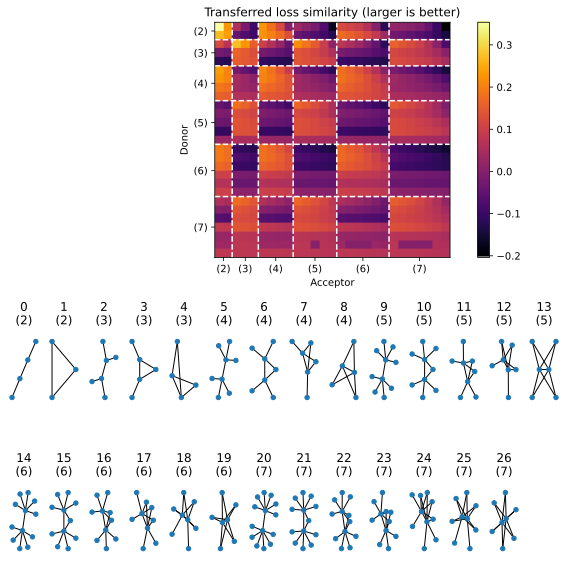

In [ ]:
from matplotlib import pyplot
from matplotlib import gridspec
graphs = g_all

d_max = 7

fig = pyplot.figure(figsize=(8, 8))

n1 = 14
n2 = 27

gs0 = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(1, n1, subplot_spec=gs0[1])
gs02 = gridspec.GridSpecFromSubplotSpec(1, n2 - n1 + 1, subplot_spec=gs0[2])

ax_mat = fig.add_subplot(gs0[0])
plt.sca(ax_mat)

if False:
    f = plt.pcolormesh(mat, cmap='inferno')
else:
    f = plt.imshow(mat/10, cmap='inferno')
    plt.xticks([i*i/2 - 1.5 for i in range(2, d_max + 1)], labels=[f"({i})" for i in range(2, d_max + 1)])
    plt.yticks([i*i/2 - 1.5 for i in range(2, d_max + 1)], labels=[f"({i})" for i in range(2, d_max + 1)])
    
plt.colorbar(f, shrink=1)
plt.title('Transferred loss similarity (larger is better)')
plt.ylabel('Donor')
plt.xlabel('Acceptor')
for i in range(2, 7):
    plt.axvline(x=i*(i + 1)/2 - 1.5, color='w', linestyle='--')
    plt.axhline(y=i*(i + 1)/2 - 1.5, color='w', linestyle='--')

for i, g in enumerate(graphs[0:n1]):
    ax00 = fig.add_subplot(gs01[i])
    plt.sca(ax00)
    plt.title(f'{i}\n({d_all[i]})')
    plt.margins(0.2, 0.2)
    nx.draw_kamada_kawai(g, node_size=20)
plt.tight_layout()

for i in range(n1, n2):
    g = graphs[i]
    ax00 = fig.add_subplot(gs02[i - n1])
    plt.sca(ax00)
    plt.title(f'{i}\n({d_all[i]})')
    plt.margins(0.2, 0.2)
    nx.draw_kamada_kawai(g, node_size=20)
plt.tight_layout()